In [1]:
import pandas as pd
from pandas import option_context

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from typing import List, Tuple, Dict, Union, Optional
import random
import glob
random.seed(0)
import dataframe_image as dfi
import re
from collections import Counter

from scipy.stats import normaltest, ttest_ind, tukey_hsd

pd.set_option('max_colwidth', 400) # avoid trimming cells
pd.set_option('display.max_columns', None) # avoid trunting columns
pd.set_option('display.max_rows', None) # avoid truncating rows

Matplotlib created a temporary config/cache directory at /data/tkew/tmp/36870/matplotlib-zd90cx1b because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
exp_seeds = [23, 42, 1984]
resource_path = Path('resources/models')
plot_path = Path(f'resources/plots')
plot_path.mkdir(parents=True, exist_ok=True)

In [38]:
name_mapping = {
    'gen_setting': 'Generation Setting',
    'bart_base': 'BART-base',
    'bart_large': 'BART-large',
    't5_small': 'T5-small',
    't5v11_small': 'T5v1.1-small',
    't5_base': 'T5-base',
    't5v11_base': 'T5v1.1-base',
    't5_lm_small': 'T5-small-LM',
    't5_lm_base': 'T5-base-LM',
    'model': 'Model',
    'len_mean': 'Avg. length',
    'qc_turn_level': '% of inquisitive responses',
    'ec_turn_level': '% of emphatic responses',
    'default': 'Default', 
    'qu_ctxt_aug1': 'CTX. AUG. (?) (attn=1)', 
    'qu_ctxt_aug5': 'CTX. AUG. (?)',
    'pos_sent_ctxt_aug5': 'CTX. AUG. (+\'ve)',
    'neg_sent_ctxt_aug5': 'CTX. AUG. (-\'ve)',
    # 'neu_sent_ctxt_aug5': 'CTX. AUG. ',
    'excl_ctxt_aug5': 'CTX. AUG. (!)',
    'single_qu_ctxt_aug5': 'CTX. AUG. (1x ?)',
    'ambig_qu_ctxt_aug5': 'CTX. AUG. (amb. ?)',
    'ambig_excl_ctxt_aug5': 'CTX. AUG. (amb. !)',
    'short_qu_ctxt_aug5': 'CTX. AUG. (short ?)',
    'e_words_ctxt_aug5': 'CTX. AUG. (epi.)',
    'd_words_ctxt_aug5': 'CTX. AUG. (dox.)',
    'n_words_ctxt_aug5': 'CTX. AUG. (cond.)',
    'i_words_ctxt_aug5': 'CTX. AUG. (inv.)',
    'hedging_contrast_ctxt_aug5': 'CTX. AUG. (contr.)',
    'hedging_management_ctxt_aug5': 'CTX. AUG. (man.)',
    'hedging_evasion_ctxt_aug5': 'CTX. AUG. (ev.)',
    'hedging_contrast': '% of contrastive hedge responses',
    'hedging_management': '% of management hedge responses',
    'hedging_evasion': '% of evasion hedge responses',
    'E_sents': '% of epistemic responses',
    'D_sents': '% of doxatic responses',
    'N_sents': '% of condition responses',
    'I_sents': '% of investigation responses',
    'pos_sents': '% of positive responses',
    'neg_sents': '% of negative responses',
    'neu_sents': '% of neutral responses',
    # 'SI(BART)': "$\mathregular{SI_{BART}}$",
    # 'SI(MASS)': "$\mathregular{SI_{MASS}}$",
    # 'SI(T5)': "$\mathregular{SI_{T5}}$",
    'SI(BART)': "$\mathregular{SI_{FR}}$",
    'SI(MASS)': "$\mathregular{SI_{PR-MS}}$",
    'SI(T5)': "$\mathregular{SI_{PR-T5}}$",
    'bart_small-MLM_PS': 'MLM-PS', 
    'bart_small-MLM': 'MLM', 
    'bart_small-PS': 'PS', 
    # 'bart_small-SI_mass': "$\mathregular{SI_{MASS}}$",
    # 'bart_small-SI_t5': "$\mathregular{SI_{T5}}$",
    # 'bart_small-SI_bart': "$\mathregular{SI_{BART}}$",
    'bart_small-SI_mass': "$\mathregular{SI_{PR-MS}}$",
    'bart_small-SI_t5': "$\mathregular{SI_{PR-T5}}$",
    'bart_small-SI_bart': "$\mathregular{SI_{FR}}$",
    'MLM+PS': 'MLM+PS',
    'MLM': 'MLM',
    'PS': 'PS',
    'bertscore_f1_mean': 'BERTscore F1', # used by sim scores to single question context
    'rouge1': 'ROUGE-1', # used by sim scores to single question context
    'bleu': 'BLEU', # used by sim scores to single question context
    'exact_match': 'Exact match', # used by sim scores to single question context
    'bart_small_rndm': "No PT",
    'rouge1_s': 'ROUGE-1 (src)',
    'bleu_t': 'BLEU',
    'ppl_mean': 'PPL',
    "intra_dist1": "Dist-1 (intra)",
    "inter_dist1": "Dist-1 (inter)",
    "self_bleu": "Self-BLEU",
    "bleu_t": "BLEU",
    "rouge1_t": "ROUGE-1",
    "rouge2_t": "ROUGE-2",
    "rougeL_t": "ROUGE-L",
    "bleu_d": "BLEU (dialog)",
    "rouge1_d": "ROUGE-1 (dialog)",
    "rouge2_d": "ROUGE-2 (dialog)",
    "rougeL_d": "ROUGE-L (dialog)",
    "bleu_k": "BLEU (knowledge)",
    "rouge1_k": "ROUGE-1 (knowledge)",
    "rouge2_k": "ROUGE-2 (knowledge)",
    "rougeL_k": "ROUGE-L (knowledge)",
    "bleu_s": "BLEU (source)",
    "rouge1_s": "ROUGE-1 (source)",
    "rouge2_s": "ROUGE-2 (source)",
    "rougeL_s": "ROUGE-L (source)",
    "meteor_t": "METEOR",
    "novelty_s_1gram": "% novel N-grams",
    "uniq": "% unique responses",
}

### Inspect generated outputs

In [39]:
def parse_generations_file_stem(stem: str) -> Tuple:
    """
    generations_test_freq_seed=0_ml=40_lp=1.0_ns=1_bs=4_ds=1_temp=0.7_tk=0_tp=0.9.txt
    """
    parts = stem.split('_')
    gen_seed = int(parts[3].split('=')[-1])
    gen_setting = None
    if len(parts) == 12 and parts[-1] == 'tp=0.9':
        # ['generations', 'test', 'freq', 'seed=42', 'ml=40', 'lp=1.0', 'ns=1', 'bs=4', 'ds=1', 'temp=0.7', 'tk=0', 'tp=0.9']
        gen_setting = 'default'
    else:
        # 'xatt=5-dialog' -> 'xatt=5-dialog', 'ctxt=5-train', 'pos', 'sents-10' -> 'ctxt=5-train_pos_sents-10'
        gen_setting = '_'.join(parts[12:])
    return (gen_setting, gen_seed)
    
def quick_lc(file: Union[str, Path]) -> int:
    with open(file, 'rb') as f:
        return sum(1 for line in f)
    
def read_lines(file: Union[str, Path], line_indices: Optional[List[int]]=None) -> List[str]:
    lines = []
    with open(file, 'r', encoding='utf8') as f:
        for i, line in enumerate(f):
            if line_indices and i not in line_indices:
                pass
            else:
                lines.append(line.strip())
    return lines

def sample_line_indices(lc: int, n: int) -> List[int]:
    return random.sample(range(lc), n)
    
def get_outputs_dataframe(model_path: Path, sample_n: int = 10) -> pd.DataFrame:
    # checkpoint_dir = get_best_checkpoint(model_path)
    file_list = list((model_path / f'outputs').glob('generation*'))
    
    if sample_n > 0:
        expected_lc = quick_lc(file_list[0])
        sample_lines = sample_line_indices(expected_lc, sample_n)
        print(sample_lines)
    else:
        sample_lines = None
    
    d = {}
    for file in file_list:
        d[parse_generations_file_stem(file.stem)] = read_lines(file, sample_lines)
    # load dictionary into dataframe, splitting the key tuple into a multiIndex
    df = pd.DataFrame(d.values(), index=pd.MultiIndex.from_tuples(d.keys(), names=['gen_setting', 'seed']))
    df = df.sort_values(by=['gen_setting', 'seed'], ascending=True)
    return df

# model_path = Path('resources/models/seed_42/ft/bart_small_rndm')
model_path = Path('resources/models/seed_42/ft/bart_small_rndm')
sampled_outputs = get_outputs_dataframe(model_path, sample_n=10)
sampled_outputs.head(10)

[3578, 8268, 2281, 4617, 2289, 1553, 4104, 8725, 2407, 5081]


0  \
gen_setting               seed                                                               
ctxt=1-train_questions-10 0                   Yeah. Do you know that the first first line?   
                          42                                            I don't know that.   
                          284                               I think it was a lot of money.   
                          983                                                I'm not sure.   
                          8630             I know. Did you know that the first first line?   
ctxt=5-D_words-10         0     I know that. Did you know that the first first first line?   
                          42                                            I don't know that.   
                          284                                           I don't know that.   
                          983                          Yeah, I think it was a lot of money   
                          8630                                          I don't know that.   

                                                                                                     1  \
gen_setting               seed                                                                           
ctxt=1-train_questions-10 0                                                 I agree. Do you know that?   
                          42                                      I don't know that. Do you know that?   
                          284                                     I have heard that. Do you know that?   
                          983                   I agree. Do you know that the pone is a lot of people?   
                          8630  I think it is a lot of people. Did you know that the Fphone has a lot?   
ctxt=5-D_words-10         0                                  I am not sure. Do you know that the pone?   
                          42                                       I agree. Do you know that the pone?   
                          284                                     I don't know that. Do you know that?   
                          983                                          I'm not sure. Do you know that?   
                          8630                                    I don't know that. Do you know that?   

                                                                                   2  \
gen_setting               seed                                                         
ctxt=1-train_questions-10 0                    I do not know that. Do you know that?   
                          42                    I don't know that. Do you know that?   
                          284                   I don't know that. Do you know that?   
                          983   I don't know that. I wonder if it is a lot of money.   
                          8630                     I wonder if it is a lot of water.   
ctxt=5-D_words-10         0                                 Yeah, I don't know that.   
                          42              I don't know that. Do you know that a lot?   
                          284           I don't know that. Do you know that the way?   
                          983                   I don't know that. Do you know that?   
                          8630                            I agree. Do you know that?   

                                                                                                  3  \
gen_setting               seed                                                                        
ctxt=1-train_questions-10 0                I agree. Did you know that the movie was a lot of money?   
                          42                   I didn't know that. Did you know that the Lemememet?   
                          284                        I agree. Did you know that Martinemememocrats?   
                          983                          I agree. Did you know that the Martinememem?   
            

### Emprical analysis for question context controlled generation

In [40]:
INDEX_LEVELS = ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']

def get_all_results(exp_seed_runs=[23], resource_path=resource_path, results_dir='results_topchat_kgd_test_freq', build_dataframe=True):
    """
    given a list of experiment seeds and the resource path directory, gather up all the results csv files we can find
    """
    model_c = Counter()
    result_c = Counter()
    
    dfs = []
    for seed in exp_seed_runs:
        exp_dir = resource_path / f'seed_{seed}'
        model_names = [p.name for p in Path(exp_dir / 'ft').iterdir()]
        print(f'\nFound {len(model_names)} models for seed {seed}: {model_names}')
        model_c.update(model_names)
        
        results_path = exp_dir / results_dir
        if build_dataframe:
            result_file_list = list(results_path.glob(f'*.csv'))
            print(f'Found {len(result_file_list)} results files in corresponding results directory ({results_path})')
            result_c.update(map(str, result_file_list))
            df = load_results_dataframe(result_file_list, verbose=False)
            dfs.append(df)

    print('\nFound models for the following experiment runs:\n')
    print(model_c)
    
    # print('\nFound results for the following experiment runs:\n')
    # print(result_c)

    df = pd.concat(dfs, axis=0) if len(dfs) else None
    if df is not None:
        print(f'Dataframe has {len(df)} entries')

    return df
    
def parse_results_filepath(file: Path) -> Tuple:
    """parses information from results file name such as, e.g.
    - bart_base-qu_ctxt_aug1.csv
    - bart_small-SI_bart-qu_ctxt_aug5.csv 
    - bart_small-SI_mass-0.25-qu_ctxt_aug1.csv
    """
    exp_seed = int(file.parts[2].split('_')[-1])
    parts = file.stem.split('-')
    model, chkpt, pt_config, exp_setting, gen_setting = None, None, None, None, None
    # print(parts)
    # if len(parts) == 2:
    #     model, gen_setting = parts # bart_base-qu_ctxt_aug1.csv -> model name, generation setting
    if len(parts) == 3: # ['bart_base', 'best', 'xa_knowledge+qu_ctxt_aug5'] 
        model, chkpt, gen_setting = parts
    elif len(parts) == 4: # ['bart_small', 'MLM', 'best', 'baseline']
        model, pt_config, chkpt, gen_setting = parts
    else:
        raise RuntimeError(f'Failed to parse file with: {parts}')

    if gen_setting == 'baseline': # rename baseline as default
        gen_setting = 'default'
        
    if not pt_config:
        pt_config = model
    else: # tidy up names
        pt_config = pt_config.replace('_bart5_25', '(BART5:25)')
        pt_config = pt_config.replace('_bart5_50', '(BART5:50)')
        pt_config = pt_config.replace('_bart5_75', '(BART5:75)')
        pt_config = pt_config.replace('_bart', '(BART)')
        pt_config = pt_config.replace('_t5', '(T5)')
        pt_config = pt_config.replace('_mass', '(MASS)')
        pt_config = pt_config.replace('_', '+')

    if chkpt and chkpt != 'best':
        chkpt = int(chkpt.split('_')[-1])
    
    ft_data_size = 1.0 # default values assumed
    if exp_setting is not None and exp_setting[0].isdigit():       
        ft_data_size = float(exp_setting)
    
    return exp_seed, pt_config, ft_data_size, chkpt, gen_setting    
        
def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def scale_values(df):
    bleu_cols = [col for col in df.columns if 'bleu' in col]
    print(f"scaling {bleu_cols} between [0,1]")
    for col in bleu_cols:
        df[col] = df[col] / 100
    return df

def load_results_dataframe(result_file_list: List, verbose: bool = False) -> pd.DataFrame:
    
    dfs = []
    for file in result_file_list:    
        if verbose:
            print(f'Loading data from {file} ...')
        df = pd.read_csv(file, sep=',', header=0, index_col=None)
        if len(df) != 5:
            print(f'Skipping {file} only has {len(df)} entries!')
        else:
            df['exp_seed'], df['model'], df['ft_data_size'], df['chkpt'], df['gen_setting'] = parse_results_filepath(file)
            df['file'] = file.stem
            df = df.rename(columns={'self_bleu_t': 'self_bleu'}) # temp fix
            # if not any(df['seed'].isnull()):
            #     print(f"check seed in {file}. Found value of {df['seed']}")
            # df['gen_seed'] = df['seed'].astype('int32')
            dfs.append(df)

    # check that all dfs have same length
    df_lengths = list(map(len,dfs))
    if len(set(df_lengths)) == 1:
        print(f"{len(dfs)} DFs have length {df_lengths[0]}")
    else:
        print(f"[!] DF lengths are not consistent! {df_lengths}")
    
    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    # standardise concatenated dataframe
    df.set_index(INDEX_LEVELS, inplace=True)
    df = df.sort_values(by=INDEX_LEVELS, ascending=True)
    df = scale_values(df)
    
    if verbose:
        print(f'\nResults table contains:')
        for col_name in df.columns.to_list():
              print(f'\t{col_name}')
        print(f'Dataframe index:')
        print(f'\t{df.index}')
        print(f'Dataframe has {len(df)} entries')
    return df

def get_detailed_info_on_complex_dataframe(df):
    
#     print('Index Columns:')
#     for name in df.index.names:
#         print(f'\t{df.index.get_level_values(name).unique()}')
#     print()
    
    print('Index columns value counts:\n')
    for name in df.index.names:
        print(f'{df.index.get_level_values(name).value_counts()}')
    print()

    print(f'Dataframe columns:')
    print(f'\t{df.columns}')
    print()
    return

In [41]:
public_model_results_df = get_all_results(exp_seeds, results_dir='results/topchat_kgd_test_freq-public_models', build_dataframe=True)
get_detailed_info_on_complex_dataframe(public_model_results_df)
public_model_results_df.head(8)


Found 30 models for seed 23: ['bart_small-SI_bart5_50', 'bart_small_rndm', 't5v11_base', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 't5_small', 'bart_large', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 't5v11_small', 'bart_small-SI_mass']
Found 116 results files in corresponding results directory (resources/models/seed_23/results/topchat_kgd_test_freq-public_models)
116 DFs have length 5
scaling ['self_bleu', 'bleu_t', 'bleu_k', 'bleu_d', 'bleu_s'] between [0,1]

Found 17 models for seed 42: ['bart_small-SI_bart5_50', 'bart_small_rndm', 't5v11_base', 'bart_

model_name_or_path  \
exp_seed model     gen_setting          chkpt ft_data_size seed                                          
23       bart_base ambig_excl_ctxt_aug5 best  1.0          0     resources/models/seed_23/ft/bart_base   
                                                           42    resources/models/seed_23/ft/bart_base   
                                                           284   resources/models/seed_23/ft/bart_base   
                                                           983   resources/models/seed_23/ft/bart_base   
                                                           8630  resources/models/seed_23/ft/bart_base   
                   ambig_qu_ctxt_aug5   best  1.0          0     resources/models/seed_23/ft/bart_base   
                                                           42    resources/models/seed_23/ft/bart_base   
                                                           284   resources/models/seed_23/ft/bart_base   

                                                                 checkpoint_dir  \
exp_seed model     gen_setting          chkpt ft_data_size seed                   
23       bart_base ambig_excl_ctxt_aug5 best  1.0          0                NaN   
                                                           42               NaN   
                                                           284              NaN   
                                                           983              NaN   
                                                           8630             NaN   
                   ambig_qu_ctxt_aug5   best  1.0          0                NaN   
                                                           42               NaN   
                                                           284              NaN   

                                                                 batch_size  \
exp_seed model     gen_setting          chkpt ft_data_size seed               
23       bart_base ambig_excl_ctxt_aug5 best  1.0          0            120   
                                                           42           120   
                                                           284          120   
                                                           983          120   
                                                           8630         120   
                   ambig_qu_ctxt_aug5   best  1.0          0            120   
                                                           42           120   
                                                           284          120   

                                                                                                      test_file  \
exp_seed model     gen_setting          chkpt ft_data_size seed                                                   
23       bart_base ambig_excl_ctxt_aug5 best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                           42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                           284   resources/data/Topical-Chat/KGD/test_freq.json   
                                                           983   resources/data/Topical-Chat/KGD/test_freq.json   
                                                           8630  resources/data/Topical-Chat/KGD/test_freq.json   
                   ambig_qu_ctxt_aug5   best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                           42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                           284   resources/data/Topical-Chat/KGD/test_freq.json   

                                                                 data_seed  \
exp_seed model     gen_setting          chkpt ft_data_size seed              
23       bart_base ambig_excl_ctxt_aug5 best  1.0          0             0   
                

In [42]:
small_model_results_df = get_all_results(exp_seeds, results_dir='results/topchat_kgd_test_freq-bart_small', build_dataframe=True)
get_detailed_info_on_complex_dataframe(small_model_results_df)
small_model_results_df.head(8)


Found 30 models for seed 23: ['bart_small-SI_bart5_50', 'bart_small_rndm', 't5v11_base', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 't5_small', 'bart_large', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 't5v11_small', 'bart_small-SI_mass']
Found 214 results files in corresponding results directory (resources/models/seed_23/results/topchat_kgd_test_freq-bart_small)
214 DFs have length 5
scaling ['self_bleu', 'bleu_t', 'bleu_k', 'bleu_d', 'bleu_s'] between [0,1]

Found 17 models for seed 42: ['bart_small-SI_bart5_50', 'bart_small_rndm', 't5v11_base', 'bart_sma

model_name_or_path  \
exp_seed model gen_setting          chkpt ft_data_size seed                                               
23       MLM   ambig_excl_ctxt_aug5 best  1.0          0     resources/models/seed_23/ft/bart_small-MLM   
                                                       42    resources/models/seed_23/ft/bart_small-MLM   
                                                       284   resources/models/seed_23/ft/bart_small-MLM   
                                                       983   resources/models/seed_23/ft/bart_small-MLM   
                                                       8630  resources/models/seed_23/ft/bart_small-MLM   
               ambig_qu_ctxt_aug5   best  1.0          0     resources/models/seed_23/ft/bart_small-MLM   
                                                       42    resources/models/seed_23/ft/bart_small-MLM   
                                                       284   resources/models/seed_23/ft/bart_small-MLM   

                                                             checkpoint_dir  \
exp_seed model gen_setting          chkpt ft_data_size seed                   
23       MLM   ambig_excl_ctxt_aug5 best  1.0          0                NaN   
                                                       42               NaN   
                                                       284              NaN   
                                                       983              NaN   
                                                       8630             NaN   
               ambig_qu_ctxt_aug5   best  1.0          0                NaN   
                                                       42               NaN   
                                                       284              NaN   

                                                             batch_size  \
exp_seed model gen_setting          chkpt ft_data_size seed               
23       MLM   ambig_excl_ctxt_aug5 best  1.0          0            120   
                                                       42           120   
                                                       284          120   
                                                       983          120   
                                                       8630         120   
               ambig_qu_ctxt_aug5   best  1.0          0            120   
                                                       42           120   
                                                       284          120   

                                                                                                  test_file  \
exp_seed model gen_setting          chkpt ft_data_size seed                                                   
23       MLM   ambig_excl_ctxt_aug5 best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                       42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                       284   resources/data/Topical-Chat/KGD/test_freq.json   
                                                       983   resources/data/Topical-Chat/KGD/test_freq.json   
                                                       8630  resources/data/Topical-Chat/KGD/test_freq.json   
               ambig_qu_ctxt_aug5   best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                       42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                       284   resources/data/Topical-Chat/KGD/test_freq.json   

                                                             data_seed  \
exp_seed model gen_setting          chkpt ft_data_size seed              
23       MLM   ambig_excl_ctxt_aug5 best  1.0          0             0   
                                                       42            0   
                                                       284       

In [43]:
print(len(public_model_results_df))
print(len(small_model_results_df))
df = pd.concat([public_model_results_df, small_model_results_df])
print(len(df))

1740
3210
4950


In [44]:
# # SI+PS is not available for all exp seeds, so drop it.
# df = df.drop('SI+PS', level=1, axis=0)
# # df = df.iloc[df.index.get_level_values('ft_data_size') == 1.0] # select only those entries which use 100% fine-tuning data
# # df = df[df.index.get_level_values('chkpt') == 'best']# select only those entries which use the best model (not checkpoints)
# get_detailed_info_on_complex_dataframe(df)

### generate tables highlighting metric differences

In [45]:
def calculate_diffs(df, target, baseline):
    if baseline in df.index and target in df.index:
        df.loc[target][:] = df.loc[target] - df.loc[baseline]
    else:
        print(f'{baseline} or {target} missing from DF.')
    return df

def highlight_max(s):
    return np.where(s == np.nanmax(s.to_numpy()), f"font-weight:bold;", None)

def style_nums(v):
    if v < 0:
        return 'color:red;'
    elif v > 0:
        return 'color:MediumSeaGreen;'
    else:
        return None

def style_dataframe(df, show_only=None):
    """formats a given dataframe with baseline rows and performance diff rows"""

    baselines_settings = list(set(['default', 'xa_dialog', 'xa_knowledge']))
    print('BASELINES:', baselines_settings)
    # experiment_settings = list(set([key[2] for key in df.index if key[2] not in baselines_settings]))
    experiment_settings = list(set([key for key in df.index if key not in baselines_settings]))
    # experiment_settings = [i for i in df.index if i not in baseline_settings]
    print('EXPERIMENT SETTINGS:', experiment_settings)
    
    s = df.style # init style object from df

    # remove alternating row colors
    s.set_table_styles([
        {
            "selector":"thead",
            "props":[("background-color","white")]
        },
        {
            "selector":"tbody tr:nth-child(even)",
            "props":[("background-color","white")]
        },
    ])
    
    # grey out baseline rows border-bottom: 1px solid black;
    s.apply(lambda s: np.where(s.index.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    s.apply_index(lambda s: np.where(s.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    
    # color values (elementwise)
    s.applymap(style_nums, subset=(experiment_settings, slice(None)))

    # find max from each row
    # s.apply(highlight_max, axis=1)
    
    # format numbers
    s.format(lambda x: f'{x*100:.2f}')
    # s.format(lambda x: x*100).format(precision=2)
    # , subset=[:, 1:]
    
    if show_only is not None:
        print(f'Showing only {show_only} ...')
        ignore = [gs for gs in s.index if gs not in show_only]
        print(f'Ignoring {ignore} ...')
        s.hide(subset=ignore, axis=0, level=None, names=False)

    # format index names
    # s.format_index(lambda x: name_mapping.get(x), axis=1, na_rep='MISS')
    # s.sort_values(by=['default'], axis=0)
    
    return s

def aggregate_values_for_target_metric(df, agg_ops: Dict = {'qc_sent_level': np.mean}):
    
    print(f'Dataframe has length: {len(df)}')
    
    if set(df.index.get_level_values('ft_data_size').values) != set([1.0]):
        print(f"[!] Found multiple fine-tuning data sizes: {set(df.index.get_level_values('ft_data_size').values)}")
    if set(df.index.get_level_values('chkpt').values) != set(['best']):
        print(f"[!] Found multiple checkpoint values: {set(df.index.get_level_values('chkpt').values)}")
               
    # aggregate values
    print(f'Dataframe has index columns: {df.index.names}')
    group_by_cols = ['model', 'gen_setting']
    print(f'Will group by: {group_by_cols}')
    df = df.groupby(group_by_cols, as_index=True).agg(agg_ops)

    # apply sorting
    df = df.sort_values(group_by_cols, ascending=[1]*len(group_by_cols))

    # apply filtering on rows (if necessary)
    # df = df.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
    # df = df.iloc[df.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
    # df = df.iloc[~df.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level

    return df

def reshape(df, level=1, subset: List = None):
    """
    reshape from vertical to horizontal format
    """
    df = df.stack().unstack(0)
    df = df.reset_index(level=level, drop=True) # remove the dummy index 'gen_setting'
    # dfa = dfa.droplevel(level=0, axis=1) # remove metric index (if necessary)
    # dfa.columns = dfa.columns.droplevel() # remove metric index (if necessary)

    if subset is not None:
        df = df[subset]
    # apply filtering on columns (if necessary)
#     keep_cols = ['MLM+PS', 'MLM-RW', 'MLM-RW(T5)', 'MLM-RW+PS']
#     drop_cols = [col for col in dfa.columns if col not in keep_cols]
#     dfa = dfa.drop(columns=drop_cols, errors='ignore')
    
    # reorder columns
    print('Dataframe has columns:', list(df.columns))
    all_reordered_cols = [
        'bart_small_rndm',
        'MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR', 
        'SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',
        'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)',
        'bart_base', 
        'bart_large', 
        't5_small', 
        't5v11_small', 
        't5_lm_small',
        't5_base', 
        't5v11_base', 
        't5_lm_base',
        ]
    avail_resorted_cols = []
    for col in all_reordered_cols:
        if col in set(list(df.columns)):
            avail_resorted_cols.append(col)
            
# #     if set(reordered_cols) != set(list(dfa.columns)):
#         print('DF columns doesn\'t match provided for resorting. Check the resorted columns!')
#     else:
    print('Sorting columns as:', avail_resorted_cols)
    df = df[avail_resorted_cols]
    
    return df 

# # compute customised dataframe with experimental row showing difference between experimental result and the baseline setting
def make_diff_df(df):
    df = calculate_diffs(df, 'qu_ctxt_aug1', 'default')
    df = calculate_diffs(df, 'qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'pos_sent_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'neg_sent_ctxt_aug5', 'default')
    # df = calculate_diffs(df, 'xa_dialog+qu_ctxt_aug5', 'xa_dialog')
    # df = calculate_diffs(df, 'xa_knowledge+qu_ctxt_aug5', 'xa_knowledge')
    df = calculate_diffs(df, 'hedging_contrast_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'hedging_management_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'hedging_evasion_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'excl_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'ambig_excl_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'ambig_qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'short_qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'single_qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'e_words_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'd_words_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'i_words_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'n_words_ctxt_aug5', 'default')
    
    return df

In [46]:
def contrastive_gen_settings_barplot(df, models, gen_settings, tgt_metric, legend_outside=False, save_as=None): #data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):

    # setup figure, axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.2 * len(models), 2.5))
    
    # subset dataframe
    dfs = df.iloc[(df.index.get_level_values(1).isin(models)) & (df.index.get_level_values(2).isin(gen_settings))].reset_index()
    
    # sanity check: all compared models should have the same number of results
    # assert all(len(dfs[dfs['model'] == models[0]]) == len(dfs[dfs['model'] == model]) for model in models)
                                                                                      
    sns.barplot(
        data=dfs, 
        x="model", 
        y=tgt_metric, 
        hue="gen_setting", 
        order=models, 
        hue_order=gen_settings,
        alpha=0.7, 
        capsize=.05,
        errwidth=0.6,
        errcolor=".2",
        linewidth=0.6, 
        edgecolor=".2", 
        palette='tab10',
        ax=ax,
    )
    
    # make plot pretty
    ax.set(xlabel=None, ylabel=name_mapping.get(tgt_metric, tgt_metric), title=None)

    labels = [name_mapping.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()] # https://stackoverflow.com/questions/11244514/modify-tick-label-text
    ax.set_xticklabels(labels)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    
    
    # make legend pretty
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        labels = [name_mapping.get(label, label) for label in labels]
        if legend_outside:
            ax.legend(handles, labels, title="Generation Settings", frameon=False, framealpha=1, facecolor='white', bbox_to_anchor=(1.0, 1.0))
        else:
            ax.legend(handles, labels, title="Generation Settings", frameon=False, framealpha=1, facecolor='white')
        # ax.legend(handles, labels, title="Generation Settings", frameon=True, framealpha=0.6, facecolor='white')
    
    if save_as is not None:
        print(f'saving to {save_as}.* ...')
        # plt.savefig(f'{save_as}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'{save_as}.png', bbox_inches='tight', dpi=300)

    return


In [47]:
# generate results tables

# qdf = aggregate_values_for_target_metric(df, agg_ops={'qc_turn_level': np.mean})
# qdf = reshape(qdf, subset=[
#     'bart_small_rndm',
#     'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'])
# qdf = make_diff_df(qdf)
# qdf = style_dataframe(qdf, show_only=[
#     'default', 
#     'qu_ctxt_aug1', 
#     'qu_ctxt_aug5', 
#     'excl_ctxt_aug5',
#     'ambig_qu_ctxt_aug5',
#     'ambig_excl_ctxt_aug5',
#     'short_qu_ctxt_aug5',
#     'single_qu_ctxt_aug5',
# ])
# qdf

# qdf = aggregate_values_for_target_metric(df, agg_ops={'qc_turn_level': np.mean})
# qdf = reshape(qdf, subset=['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base'])
# qdf = make_diff_df(qdf)
# qdf = style_dataframe(qdf, show_only=[
#     'default', 
#     'qu_ctxt_aug1', 
#     'qu_ctxt_aug5', 
#     'excl_ctxt_aug5',
#     'ambig_qu_ctxt_aug5',
#     'ambig_excl_ctxt_aug5',
#     'short_qu_ctxt_aug5',
#     'single_qu_ctxt_aug5',
# ])
# qdf
# print(qdf.to_latex(hrules=True, convert_css=True))

# qdf = aggregate_values_for_target_metric(df, agg_ops={'ec_turn_level': np.mean})
# qdf = reshape(qdf, subset=['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base'])
# qdf = make_diff_df(qdf)
# qdf = style_dataframe(qdf, show_only=[
#     'default', 
#     'excl_ctxt_aug5',
#     'ambig_qu_ctxt_aug5',
#     'ambig_excl_ctxt_aug5',
# ])
# qdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'pos_sents': np.mean})
# sdf = reshape(sdf, subset=['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base'])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'pos_sent_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'neg_sents': np.mean})
# sdf = reshape(sdf, subset=['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base'])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'neg_sent_ctxt_aug5'])
# sdf

In [48]:
# contrastive_gen_settings_barplot(
#     df, 
#     models = [
#         'bart_small_rndm', 
#         'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)'], 
#     gen_settings = [
#         'default', 
#         'qu_ctxt_aug5', 
#         'qu_ctxt_aug1', 
#         'excl_ctxt_aug5', 
#         'ambig_qu_ctxt_aug5', 
#         'ambig_excl_ctxt_aug5',
#         'short_qu_ctxt_aug5',
#         'single_qu_ctxt_aug5',
#     ], 
#     tgt_metric='qc_turn_level',
#     legend_outside=True,
#     save_as=None
# )

Dataframe has length: 4950
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)']
Sorting columns as: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)']
BASELINES: ['default', 'xa_dialog', 'xa_knowledge']
EXPERIMENT SETTINGS: ['single_qu_ctxt_aug5', 'e_words_ctxt_aug5', 'qu_ctxt_aug1', 'excl_ctxt_aug5', 'ambig_qu_ctxt_aug5', 'pos_sent_ctxt_aug5', 'hedging_evasion_ctxt_aug5', 'd_words_ctxt_aug5', 'short_qu_ctxt_aug5', 'single_pos_ctxt_aug5', 'hedging_management_ctxt_aug5', 'ambig_excl_ctxt_aug5', 'xa_dialog+qu_ctxt_aug5', 'qu_ctxt_aug5', 'hedging_contrast_ctxt_aug5', 'neg_sent_ctxt_aug5', 'xa_knowledge+qu_ctxt_aug5', 'i_words_ctxt_aug5', 'n_words_ctxt_aug5']
Showing only ['default', 'qu

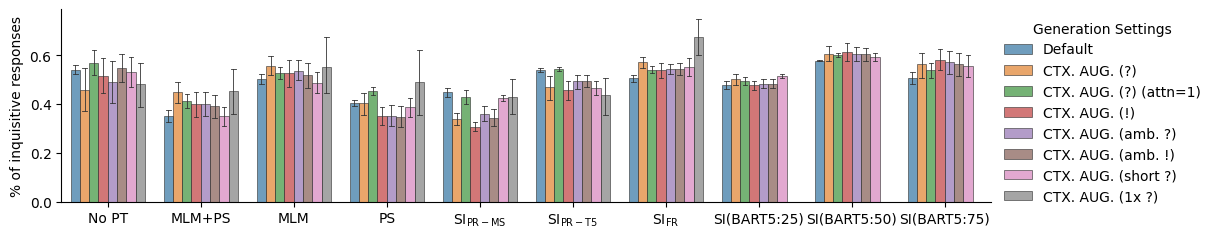

In [49]:
# generate results tables and plots
def plot_and_tabulate(df, models, gen_settings, tgt_metric):
    contrastive_gen_settings_barplot(
        df, 
        models=models, 
        gen_settings=gen_settings, 
        tgt_metric=tgt_metric,
        legend_outside=True,
        save_as=None
    )

    qdf = aggregate_values_for_target_metric(df, agg_ops={tgt_metric: np.mean})
    qdf = reshape(qdf, subset=models)
    qdf = make_diff_df(qdf)
    qdf = style_dataframe(qdf, show_only=gen_settings)
    return qdf

qdf = plot_and_tabulate(
    df, 
    models=[
        'bart_small_rndm',
        'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)',
        'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'
    ],
    gen_settings=[
            'default', 
            'qu_ctxt_aug5', 
            'qu_ctxt_aug1', 
            'excl_ctxt_aug5', 
            'ambig_qu_ctxt_aug5', 
            'ambig_excl_ctxt_aug5',
            'short_qu_ctxt_aug5',
            'single_qu_ctxt_aug5',
    ],
    tgt_metric='qc_turn_level'
)



In [50]:
qdf
# print(qdf.to_latex(hrules=True, convert_css=True))

model,bart_small_rndm,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5),SI(BART5:25),SI(BART5:50),SI(BART5:75)
gen_setting,,,,,,,,,,
ambig_excl_ctxt_aug5,0.65,4.00,1.39,-5.81,3.53,-10.36,-4.39,0.51,2.62,5.73
ambig_qu_ctxt_aug5,-5.11,4.92,3.36,-5.37,3.63,-8.90,-4.66,0.43,2.66,6.38
default,54.18,35.24,50.39,40.61,50.79,44.87,54.04,47.90,57.84,50.80
excl_ctxt_aug5,-2.43,4.76,2.42,-5.59,3.16,-14.13,-8.37,-0.08,3.52,7.52
qu_ctxt_aug1,2.84,6.11,2.29,4.90,3.41,-1.74,0.28,1.81,2.42,3.25
qu_ctxt_aug5,-8.27,9.68,5.42,-0.20,6.37,-10.90,-7.07,2.42,2.82,5.51
short_qu_ctxt_aug5,-1.04,0.07,-1.50,-1.85,4.35,-2.22,-7.34,3.70,1.38,5.05
single_qu_ctxt_aug5,-6.08,10.15,5.06,8.68,16.62,-2.03,-10.42,nan,nan,nan


Dataframe has length: 4950
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)']
Sorting columns as: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)']
BASELINES: ['default', 'xa_dialog', 'xa_knowledge']
EXPERIMENT SETTINGS: ['single_qu_ctxt_aug5', 'e_words_ctxt_aug5', 'qu_ctxt_aug1', 'excl_ctxt_aug5', 'ambig_qu_ctxt_aug5', 'pos_sent_ctxt_aug5', 'hedging_evasion_ctxt_aug5', 'd_words_ctxt_aug5', 'short_qu_ctxt_aug5', 'single_pos_ctxt_aug5', 'hedging_management_ctxt_aug5', 'ambig_excl_ctxt_aug5', 'xa_dialog+qu_ctxt_aug5', 'qu_ctxt_aug5', 'hedging_contrast_ctxt_aug5', 'neg_sent_ctxt_aug5', 'xa_knowledge+qu_ctxt_aug5', 'i_words_ctxt_aug5', 'n_words_ctxt_aug5']
Showing only ['default', 'pos_sent_ctxt_aug5'] ...
Ignoring ['ambig_excl_ctxt_aug5', 'ambig_qu_ctxt_aug5', 'd_words_ctxt_aug

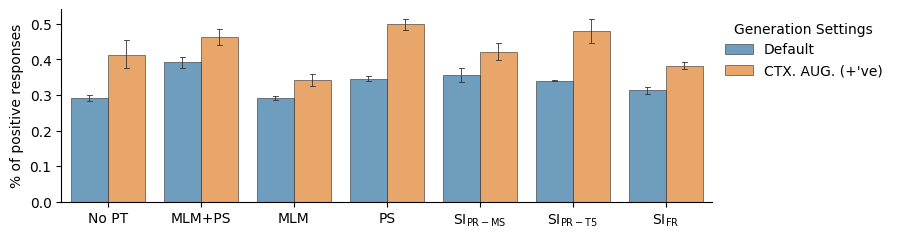

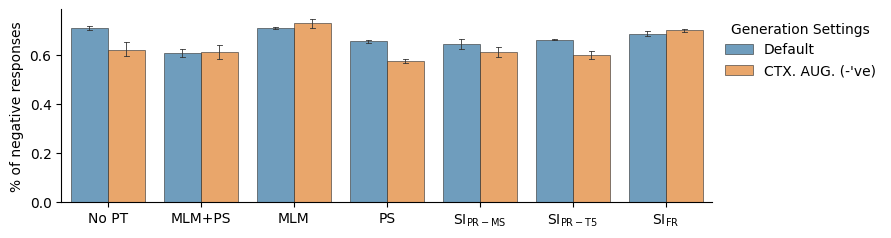

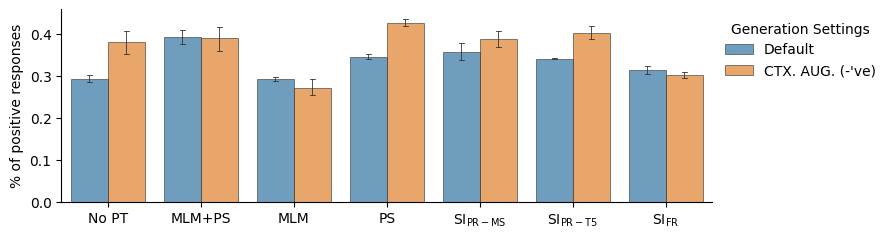

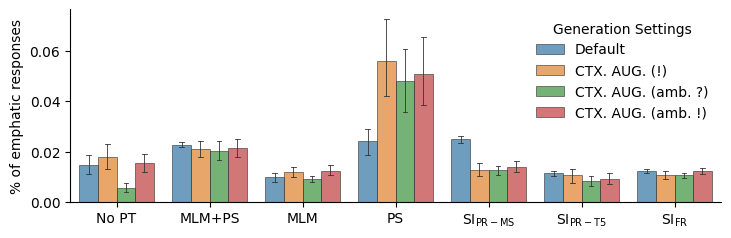

In [51]:
pdf = plot_and_tabulate(
    df, 
    models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 
            # 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'
           ],
    gen_settings=['default', 'pos_sent_ctxt_aug5',],
    tgt_metric='pos_sents'
)

ndf = plot_and_tabulate(
    df, 
    models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 
            # 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'
           ],
    gen_settings=['default', 'neg_sent_ctxt_aug5',],
    tgt_metric='neg_sents'
)

npdf = plot_and_tabulate(
    df, 
    models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 
            # 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'
           ],
    gen_settings=['default', 'neg_sent_ctxt_aug5',],
    tgt_metric='pos_sents'
)

edf = plot_and_tabulate(
    df, 
    models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 
            # 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'
           ],
    gen_settings=['default', 'excl_ctxt_aug5', 'ambig_qu_ctxt_aug5', 'ambig_excl_ctxt_aug5',],
    tgt_metric='ec_turn_level'
)

In [52]:
pdf
# print(pdf.to_latex(hrules=True, convert_css=True))

model,bart_small_rndm,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5)
gen_setting,,,,,,,
default,29.24,39.19,29.17,34.52,31.46,35.65,34.00
pos_sent_ctxt_aug5,11.99,7.12,5.11,15.33,6.71,6.47,13.93


In [53]:
ndf
# print(ndf.to_latex(hrules=True, convert_css=True))

model,bart_small_rndm,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5)
gen_setting,,,,,,,
default,70.76,60.81,70.83,65.48,68.54,64.35,66.00
neg_sent_ctxt_aug5,-8.76,0.13,1.97,-8.12,1.29,-3.13,-6.20


In [54]:
# plot_and_tabulate(
#     df, 
#     models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'],
#     gen_settings=['default', 'hedging_contrast_ctxt_aug5',],
#     tgt_metric='hedging_contrast'
# )

# plot_and_tabulate(
#     df, 
#     models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'],
#     gen_settings=['default', 'hedging_evasion_ctxt_aug5',],
#     tgt_metric='hedging_evasion'
# )

# plot_and_tabulate(
#     df, 
#     models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'],
#     gen_settings=['default', 'hedging_management_ctxt_aug5',],
#     tgt_metric='hedging_management'
# )

# plot_and_tabulate(
#     df, 
#     models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'],
#     gen_settings=['default', 'd_words_ctxt_aug5',],
#     tgt_metric='D_sents'
# )

# plot_and_tabulate(
#     df, 
#     models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'],
#     gen_settings=['default', 'e_words_ctxt_aug5',],
#     tgt_metric='E_sents'
# )

# plot_and_tabulate(
#     df, 
#     models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'],
#     gen_settings=['default', 'i_words_ctxt_aug5',],
#     tgt_metric='I_sents'
# )

# plot_and_tabulate(
#     df, 
#     models=['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)'],
#     gen_settings=['default', 'n_words_ctxt_aug5',],
#     tgt_metric='N_sents'
# )

In [55]:
# sdf = aggregate_values_for_target_metric(df, agg_ops={'pos_sents': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm'])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'pos_sent_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'neg_sents': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm'])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'neg_sent_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'hedging_evasion': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'hedging_evasion_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'hedging_management': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'hedging_management_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'D_sents': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'd_words_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'E_sents': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'e_words_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'N_sents': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'n_words_ctxt_aug5'])
# sdf

# sdf = aggregate_values_for_target_metric(df, agg_ops={'I_sents': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'i_words_ctxt_aug5'])
# sdf


saving to resources/plots/bart_small-qu_ctxt_aug5.* ...
saving to resources/plots/bart_small-pos_sent_ctxt_aug5.* ...
saving to resources/plots/bart_small-neg_sent_ctxt_aug5.* ...
saving to resources/plots/bart_small-i_words_ctxt_aug5.* ...
saving to resources/plots/bart_small-e_words_ctxt_aug5.* ...
saving to resources/plots/bart_small-d_words_ctxt_aug5.* ...
saving to resources/plots/bart_small-n_words_ctxt_aug5.* ...


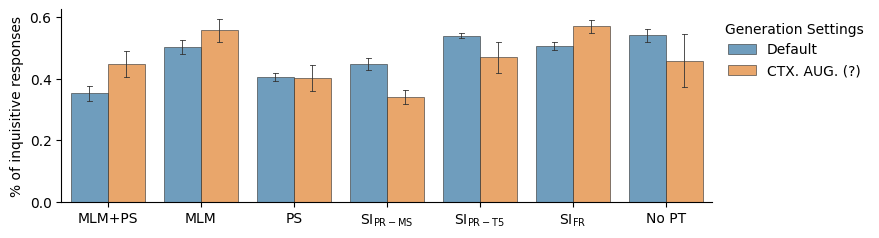

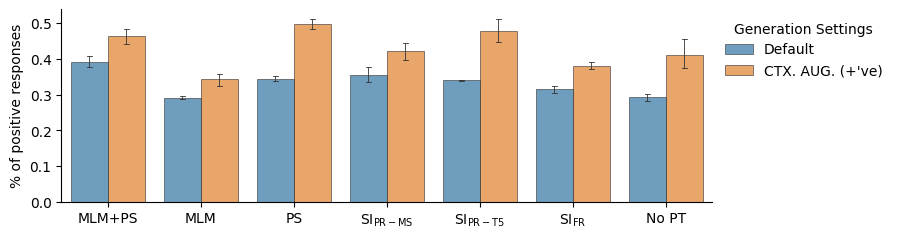

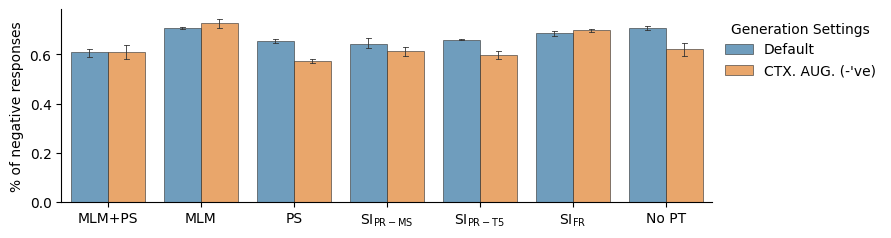

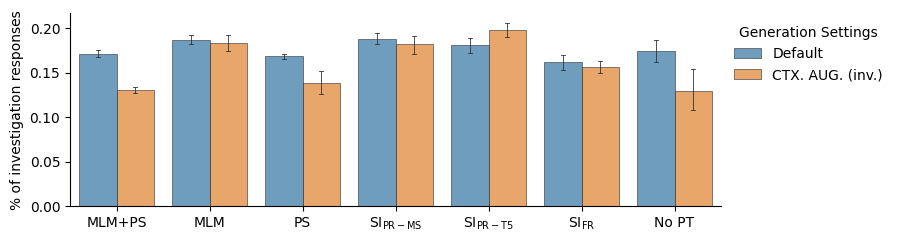

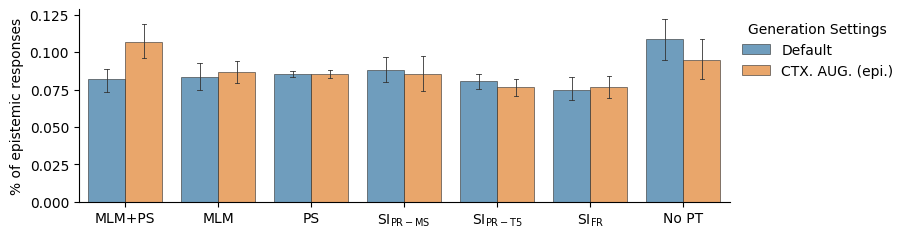

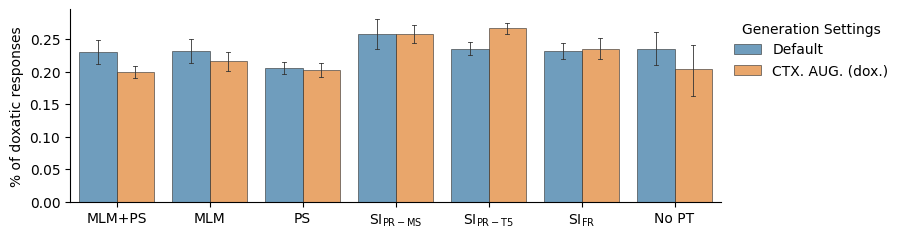

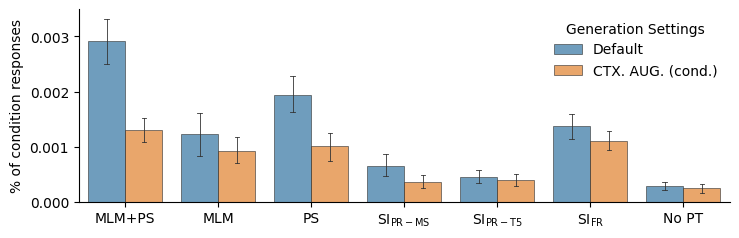

In [56]:
contrastive_gen_settings_barplot(
    df, 
    ['MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'bart_small_rndm'], 
    ['default', 'qu_ctxt_aug5'], tgt_metric="qc_turn_level",
    legend_outside=True,
    save_as="resources/plots/bart_small-qu_ctxt_aug5",
)

contrastive_gen_settings_barplot(
    df, 
    ['MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'bart_small_rndm'], 
    ['default', 'pos_sent_ctxt_aug5'], tgt_metric="pos_sents",
    legend_outside=True,
    save_as="resources/plots/bart_small-pos_sent_ctxt_aug5",
)

contrastive_gen_settings_barplot(
    df, 
    ['MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'bart_small_rndm'], 
    ['default', 'neg_sent_ctxt_aug5'], tgt_metric="neg_sents",
    legend_outside=True,
    save_as="resources/plots/bart_small-neg_sent_ctxt_aug5",
)

contrastive_gen_settings_barplot(
    df, 
    ['MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'bart_small_rndm'], 
    ['default', 'i_words_ctxt_aug5'], tgt_metric="I_sents",
    legend_outside=True,
    save_as="resources/plots/bart_small-i_words_ctxt_aug5",
)

contrastive_gen_settings_barplot(
    df, 
    ['MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'bart_small_rndm'], 
    ['default', 'e_words_ctxt_aug5'], tgt_metric="E_sents",
    legend_outside=True,
    save_as="resources/plots/bart_small-e_words_ctxt_aug5",
)

contrastive_gen_settings_barplot(
    df, 
    ['MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'bart_small_rndm'], 
    ['default', 'd_words_ctxt_aug5'], tgt_metric="D_sents",
    legend_outside=True,
    save_as="resources/plots/bart_small-d_words_ctxt_aug5",
)

contrastive_gen_settings_barplot(
    df, 
    ['MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)', 'bart_small_rndm'], 
    ['default', 'n_words_ctxt_aug5'], tgt_metric="N_sents",
    legend_outside=True,
    save_as="resources/plots/bart_small-n_words_ctxt_aug5",
)

## Statistical Significance

In [57]:
# adapted from https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/

def check_is_normal(array, threshold=0.05):
    value, p = normaltest(array)
    if p >= 0.05:
        print(f'It is likely that {array} is normal')
    else:
        print(f'It is unlikely that {array} is normal')

def run_tests(values1, values2, threshold=0.05):
    """
    Following Hazarika et al., 2022 (https://arxiv.org/abs/2106.06411),
    we compute Two-tailed unpaired t-test and Tukey's HSD between 
    baseline (default generation) and experimental settings (e.g. with CTX. AUG.)
    """

    ttest_value, ttest_pvalue = ttest_ind(values1, values2, equal_var=True)
    # print(f"Two-tailed unpaired t-test: {value}, {pvalue}")
#     if ttest_pvalue > threshold:
#         print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
#     else:
#         print(f'\tSamples are likely drawn from DIFFERENT distributions (reject H0) p={threshold} ***')
    
    tuk = tukey_hsd(values1, values2)
    HSD_value = tuk.statistic[0,1]
    HSD_pvalue = tuk.pvalue[0,1]

    # print(f"Tukey's HSD: {HSD_value}, {HSD_pvalue})")
#     if HSD_pvalue > threshold:
#         print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
#     else:
#         print(f'\tSamples are likely drawn from DIFFERENT distributions (reject H0) p={threshold} ***')
    
    if ttest_pvalue < threshold and HSD_pvalue < threshold:
        return True
    elif ttest_pvalue > threshold and HSD_pvalue > threshold:
        return False
    elif ttest_pvalue < threshold and HSD_pvalue > threshold:
        return False
    elif ttest_pvalue > threshold and HSD_pvalue < threshold:
        return False
    
def compute_significance(df, baseline_setting = "default", exp_setting = "qu_ctxt_aug5", tgt_metric = "qc_turn_level", threshold=0.05):
    
    exp_seeds = df.index.unique(level=0)
    models = df.index.unique(level=1)
    
    for model in models:
        all_runs = {}
        for exp_seed in exp_seeds:
            # print(f"Model: {model}, Seed run: {exp_seed}")
            bsl = df.iloc[(df.index.get_level_values(0) == exp_seed) & (df.index.get_level_values(1) == model) & (df.index.get_level_values(2) == baseline_setting)][tgt_metric].to_numpy()
            exp = df.iloc[(df.index.get_level_values(0) == exp_seed) & (df.index.get_level_values(1) == model) & (df.index.get_level_values(2) == exp_setting)][tgt_metric].to_numpy()    
            if len(exp) == 0:
                continue
            # print(bsl, exp)
            result = run_tests(bsl, exp, threshold=threshold)
            all_runs[exp_seed] = result
        print(f"{model}\t{''.join(['*' for i in all_runs.values() if i == True])}\t{all_runs}")
                    
    return

In [58]:
compute_significance(df, "default", "qu_ctxt_aug5", "qc_turn_level", threshold=0.01)
# compute_significance(df, "default", "single_qu_ctxt_aug5", "qc_turn_level", threshold=0.01)

bart_base	***	{23: True, 42: True, 1984: True}
bart_large	**	{23: True, 42: False, 1984: True}
t5_lm_small		{23: False, 42: False, 1984: False}
t5_small	*	{23: True, 42: False, 1984: False}
t5v11_base	*	{23: True, 42: False, 1984: False}
t5v11_small	***	{23: True, 42: True, 1984: True}
MLM	**	{23: False, 42: True, 1984: True}
MLM+PS	**	{23: True, 42: True, 1984: False}
PS	*	{23: True, 42: False, 1984: False}
SI(BART)	***	{23: True, 42: True, 1984: True}
SI(BART5:25)	**	{23: False, 42: True, 1984: True}
SI(BART5:50)	***	{23: True, 42: True, 1984: True}
SI(BART5:75)	*	{23: False, 42: True, 1984: False}
SI(MASS)	***	{23: True, 42: True, 1984: True}
SI(T5)	*	{23: False, 42: True, 1984: False}
bart_small_rndm	*	{23: False, 42: False, 1984: True}


In [59]:
compute_significance(df, "default", "pos_sent_ctxt_aug5", "pos_sents", threshold=0.01)


bart_base	***	{23: True, 42: True, 1984: True}
bart_large	**	{23: True, 42: False, 1984: True}
t5_lm_small	***	{23: True, 42: True, 1984: True}
t5_small	***	{23: True, 42: True, 1984: True}
t5v11_base	***	{23: True, 42: True, 1984: True}
t5v11_small	***	{23: True, 42: True, 1984: True}
MLM	**	{23: True, 42: False, 1984: True}
MLM+PS	***	{23: True, 42: True, 1984: True}
PS	***	{23: True, 42: True, 1984: True}
SI(BART)	***	{23: True, 42: True, 1984: True}
SI(BART5:25)	***	{23: True, 42: True, 1984: True}
SI(BART5:50)	***	{23: True, 42: True, 1984: True}
SI(BART5:75)	***	{23: True, 42: True, 1984: True}
SI(MASS)	***	{23: True, 42: True, 1984: True}
SI(T5)	***	{23: True, 42: True, 1984: True}
bart_small_rndm	***	{23: True, 42: True, 1984: True}


## Plots

In [60]:
# contrastive_gen_settings_barplot(
#     df, 
#     models = [
#         'bart_small_rndm', 
#         'MLM+PS', 'MLM', 'PS', 'SI(MASS)', 'SI(T5)', 'SI(BART)'], 
#     gen_settings = [
#         'default', 
#         'qu_ctxt_aug5', 
#     ], 
#     tgt_metric="qc_turn_level",
#     legend_outside=True,
#     save_as="resources/plots/bart_small-qu_ctxt_aug5"
# )

saving to resources/plots/all_public_models-qu_ctxt_aug5.* ...
saving to resources/plots/all_public_models-qu_ctxt_aug1.* ...
saving to resources/plots/all_public_models-pos_sent_ctxt_aug5.* ...
saving to resources/plots/all_public_models-neg_sent_ctxt_aug5.* ...
saving to resources/plots/all_public_models-hedging_contrast_ctxt_aug5.* ...
saving to resources/plots/all_public_models-hedging_management_ctxt_aug5.* ...
saving to resources/plots/all_public_models-hedging_evasion_ctxt_aug5.* ...
saving to resources/plots/all_public_models-e_words_ctxt_aug5.* ...
saving to resources/plots/all_public_models-d_words_ctxt_aug5.* ...
saving to resources/plots/all_public_models-n_words_ctxt_aug5.* ...
saving to resources/plots/all_public_models-i_words_ctxt_aug5.* ...
saving to resources/plots/public_models-qu_ctxt_aug5.* ...
saving to resources/plots/public_models-qu_ctxt_aug1.* ...
saving to resources/plots/public_models-pos_sent_ctxt_aug5.* ...
saving to resources/plots/public_models-neg_sent_

/data/tkew/tmp/36870/ipykernel_2557862/1229287009.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.2 * len(models), 2.5))


saving to resources/plots/public_models-n_words_ctxt_aug5.* ...
saving to resources/plots/public_models-i_words_ctxt_aug5.* ...


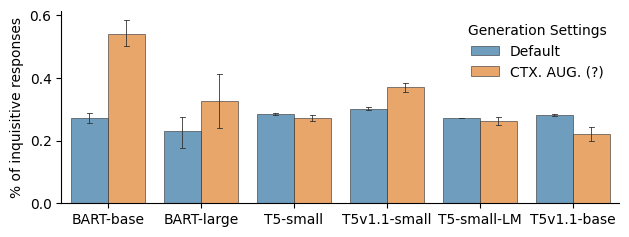

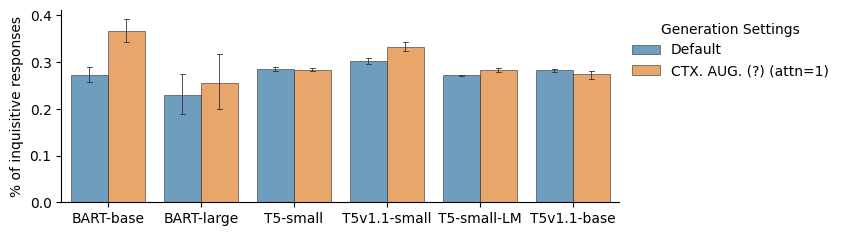

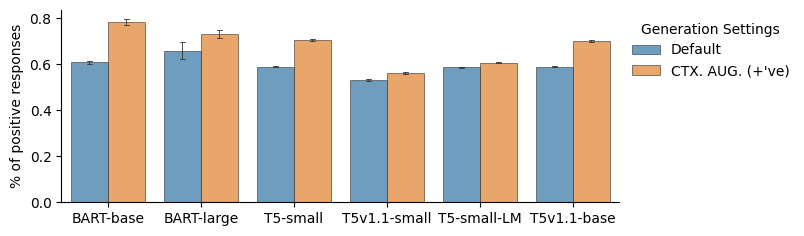

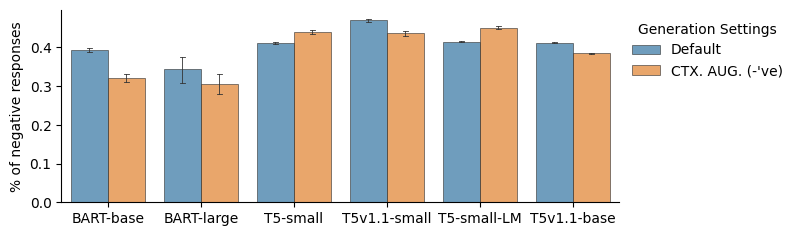

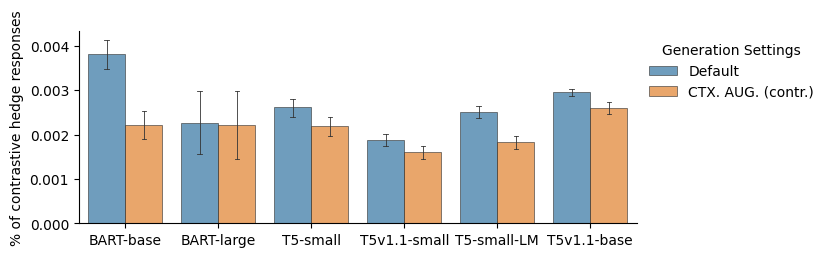

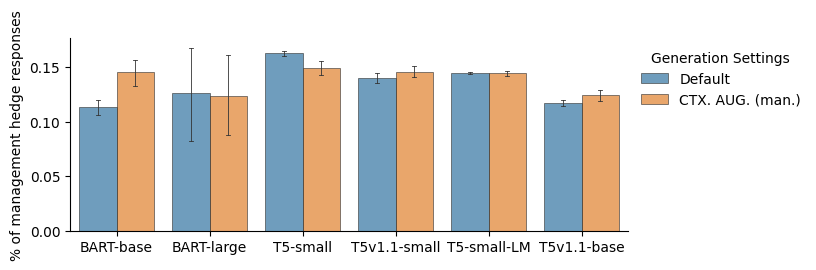

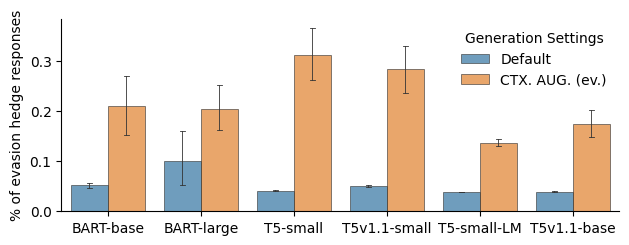

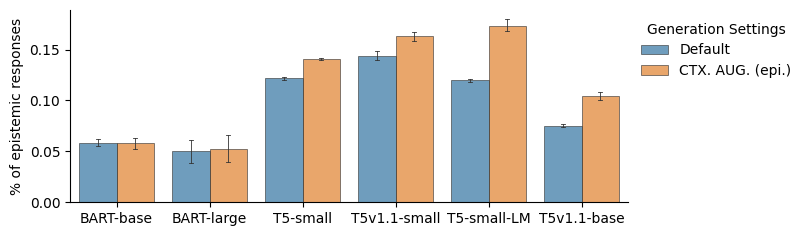

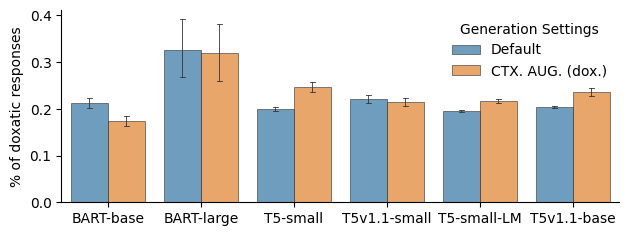

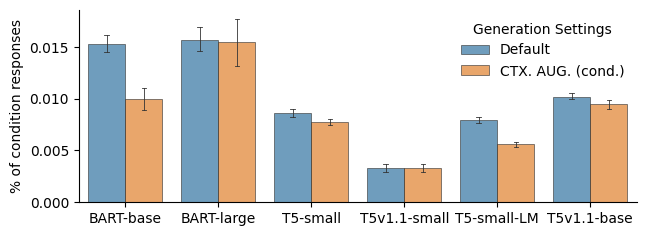

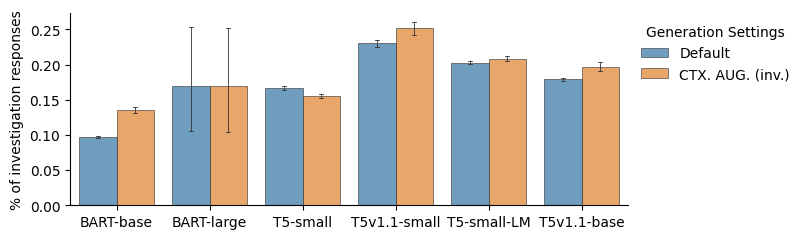

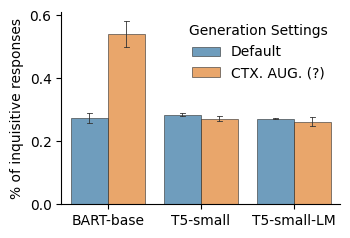

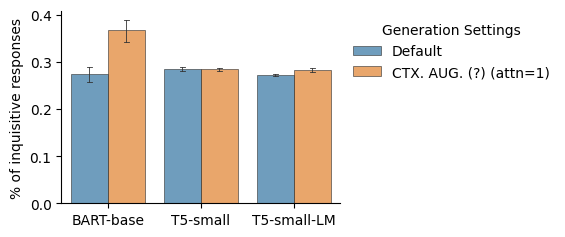

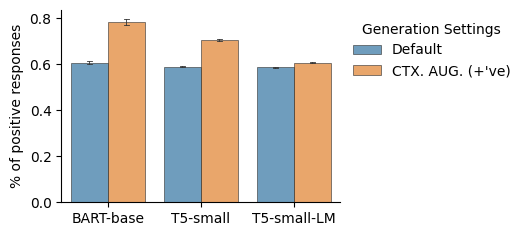

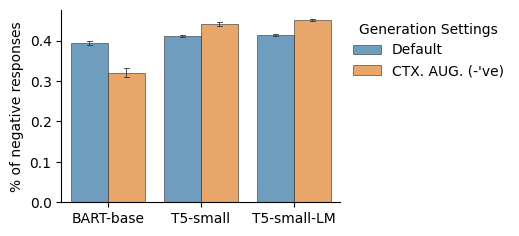

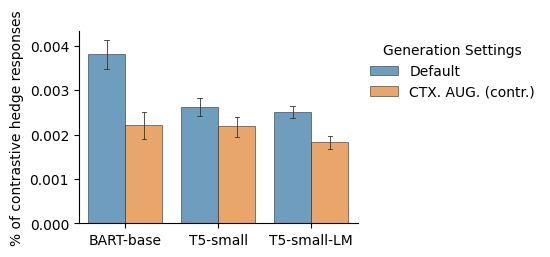

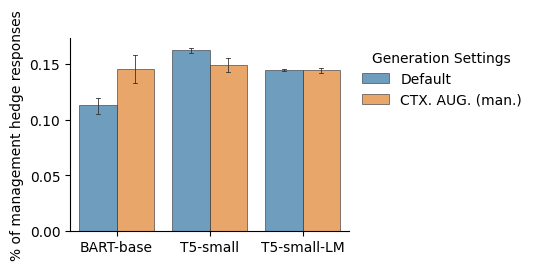

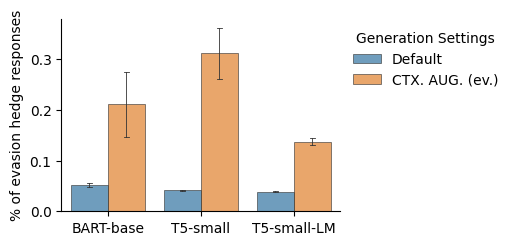

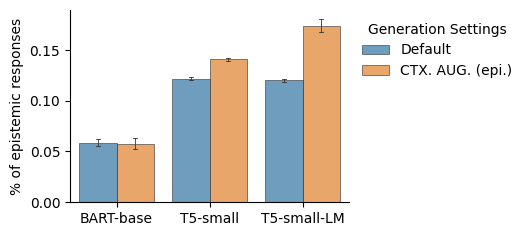

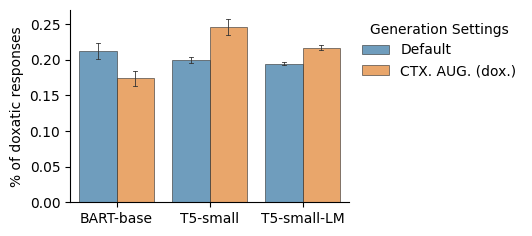

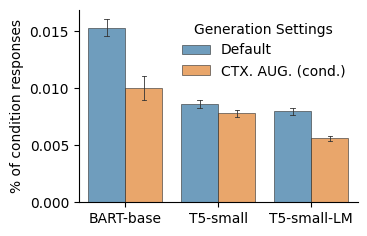

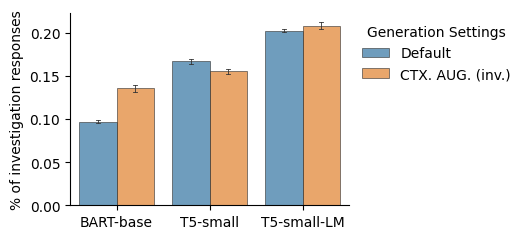

In [61]:
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'qu_ctxt_aug5'], tgt_metric="qc_turn_level", legend_outside=True, save_as='resources/plots/all_public_models-qu_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'qu_ctxt_aug1'], tgt_metric="qc_turn_level", legend_outside=True, save_as='resources/plots/all_public_models-qu_ctxt_aug1')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'pos_sent_ctxt_aug5'], tgt_metric="pos_sents", legend_outside=True, save_as='resources/plots/all_public_models-pos_sent_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'neg_sent_ctxt_aug5'], tgt_metric="neg_sents", legend_outside=True, save_as='resources/plots/all_public_models-neg_sent_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'hedging_contrast_ctxt_aug5'], tgt_metric="hedging_contrast", legend_outside=True, save_as='resources/plots/all_public_models-hedging_contrast_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'hedging_management_ctxt_aug5'], tgt_metric="hedging_management", legend_outside=True, save_as='resources/plots/all_public_models-hedging_management_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'hedging_evasion_ctxt_aug5'], tgt_metric="hedging_evasion", legend_outside=True, save_as='resources/plots/all_public_models-hedging_evasion_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'e_words_ctxt_aug5'], tgt_metric="E_sents", legend_outside=True, save_as='resources/plots/all_public_models-e_words_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'd_words_ctxt_aug5'], tgt_metric="D_sents", legend_outside=True, save_as='resources/plots/all_public_models-d_words_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'n_words_ctxt_aug5'], tgt_metric="N_sents", legend_outside=True, save_as='resources/plots/all_public_models-n_words_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'i_words_ctxt_aug5'], tgt_metric="I_sents", legend_outside=True, save_as='resources/plots/all_public_models-i_words_ctxt_aug5')

contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'qu_ctxt_aug5'], tgt_metric="qc_turn_level", legend_outside=True, save_as='resources/plots/public_models-qu_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'qu_ctxt_aug1'], tgt_metric="qc_turn_level", legend_outside=True, save_as='resources/plots/public_models-qu_ctxt_aug1')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'pos_sent_ctxt_aug5'], tgt_metric="pos_sents", legend_outside=True, save_as='resources/plots/public_models-pos_sent_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'neg_sent_ctxt_aug5'], tgt_metric="neg_sents", legend_outside=True, save_as='resources/plots/public_models-neg_sent_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'hedging_contrast_ctxt_aug5'], tgt_metric="hedging_contrast", legend_outside=True, save_as='resources/plots/public_models-hedging_contrast_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'hedging_management_ctxt_aug5'], tgt_metric="hedging_management", legend_outside=True, save_as='resources/plots/public_models-hedging_management_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'hedging_evasion_ctxt_aug5'], tgt_metric="hedging_evasion", legend_outside=True, save_as='resources/plots/public_models-hedging_evasion_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'e_words_ctxt_aug5'], tgt_metric="E_sents", legend_outside=True, save_as='resources/plots/public_models-e_words_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'd_words_ctxt_aug5'], tgt_metric="D_sents", legend_outside=True, save_as='resources/plots/public_models-d_words_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'n_words_ctxt_aug5'], tgt_metric="N_sents", legend_outside=True, save_as='resources/plots/public_models-n_words_ctxt_aug5')
contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'i_words_ctxt_aug5'], tgt_metric="I_sents", legend_outside=True, save_as='resources/plots/public_models-i_words_ctxt_aug5')


---
# Performance metrics

In [62]:
perf_metrics = {
    'uniq': [np.mean, np.std],
    'len_mean': [np.mean, np.std],
    'ppl_mean': [np.mean, np.std],
    'intra_dist1': [np.mean, np.std],
    'inter_dist1': [np.mean, np.std],
    'self_bleu': [np.mean, np.std],
    'bleu_t': [np.mean, np.std],
    # 'bleu_d': [np.mean, np.std],
    # 'bleu_k': [np.mean, np.std],
    'rouge1_t': [np.mean, np.std],
    # 'rouge2_t': [np.mean, np.std],
    # 'rougeL_t': [np.mean, np.std],
    # 'rouge1_d': [np.mean, np.std],
    # 'rouge2_d': [np.mean, np.std],
    # 'rougeL_d': [np.mean, np.std],
    # 'rouge1_k': [np.mean, np.std],
    # 'rouge2_k': [np.mean, np.std],
    # 'rougeL_k': [np.mean, np.std],
    # 'rouge1_s': [np.mean, np.std],
    # 'rouge2_s': [np.mean, np.std],
    # 'rougeL_s': [np.mean, np.std],
    'meteor_t': [np.mean, np.std],
    # 'novelty_s_1gram': [np.mean, np.std],
    # 'novelty_s_2gram': np.mean,
    # 'novelty_s_3gram': np.mean,
    # 'novelty_s_4gram': np.mean,
}
    
# produce table    
perfdf = aggregate_values_for_target_metric(df[df.index.get_level_values(2) == 'default'], agg_ops=perf_metrics)
# perfdf = reshape(perfdf, level=0)
# perfdf = perfdf.transpose()#.swaplevel(0)
# perfdf = perfdf.unstack(1)
# .swaplevel(0,1)
perfdf = perfdf.reset_index(level=1, drop=True)

perfdf.columns = perfdf.columns.map('|'.join).str.strip('|') # merge levels

# perfdf['uniq|mean']
old_cols = perfdf.columns

# # # TODO: join mean std
# # # df[:, 'uniq|mean']
perfdf = perfdf.round(decimals=2)

for i, j in zip(*[iter(perfdf.columns)]*2):
    print(type(i), i,j)
    perfdf[f"{i.split('|')[0]}"] = perfdf[i].astype('str') + ' (+- ' + perfdf[j].astype('str') + ')'
    
perfdf.drop(old_cols, axis=1, inplace=True)
perfdf.drop(['SI(BART5:25)',
             'SI(BART5:50)',
             'SI(BART5:75)',
             'bart_base',
             'bart_large',
             't5_lm_small',
             't5_small',
             't5v11_base',
             't5v11_small',
            ], axis=0, inplace=True)
# perfdf.rename(name_mapping, inplace=True)
perfdf.transpose()
# print(perfdf.to_latex())
# perfdf.to_csv('resources/performance_metric_results.csv')

Dataframe has length: 240
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
<class 'str'> uniq|mean uniq|std
<class 'str'> len_mean|mean len_mean|std
<class 'str'> ppl_mean|mean ppl_mean|std
<class 'str'> intra_dist1|mean intra_dist1|std
<class 'str'> inter_dist1|mean inter_dist1|std
<class 'str'> self_bleu|mean self_bleu|std
<class 'str'> bleu_t|mean bleu_t|std
<class 'str'> rouge1_t|mean rouge1_t|std
<class 'str'> meteor_t|mean meteor_t|std


model,MLM,MLM+PS,PS,SI(BART),SI(MASS),SI(T5),bart_small_rndm
uniq,0.67 (+- 0.02),0.76 (+- 0.01),0.68 (+- 0.01),0.68 (+- 0.02),0.7 (+- 0.01),0.7 (+- 0.02),0.57 (+- 0.06)
len_mean,16.21 (+- 0.27),15.75 (+- 0.19),15.41 (+- 0.34),15.99 (+- 0.07),15.41 (+- 0.33),16.5 (+- 0.34),13.47 (+- 0.53)
ppl_mean,54.91 (+- 3.66),59.09 (+- 2.4),57.26 (+- 2.51),53.71 (+- 1.09),60.62 (+- 3.27),58.64 (+- 0.98),50.87 (+- 6.95)
intra_dist1,0.93 (+- 0.0),0.92 (+- 0.0),0.93 (+- 0.0),0.93 (+- 0.0),0.92 (+- 0.01),0.93 (+- 0.0),0.91 (+- 0.0)
inter_dist1,0.02 (+- 0.0),0.02 (+- 0.0),0.02 (+- 0.0),0.02 (+- 0.0),0.02 (+- 0.0),0.02 (+- 0.0),0.01 (+- 0.0)
self_bleu,0.79 (+- 0.01),0.74 (+- 0.0),0.78 (+- 0.01),0.79 (+- 0.01),0.78 (+- 0.01),0.78 (+- 0.0),0.86 (+- 0.01)
bleu_t,0.03 (+- 0.0),0.03 (+- 0.0),0.03 (+- 0.0),0.03 (+- 0.0),0.03 (+- 0.0),0.04 (+- 0.0),0.01 (+- 0.0)
rouge1_t,0.21 (+- 0.0),0.2 (+- 0.0),0.2 (+- 0.0),0.21 (+- 0.0),0.2 (+- 0.0),0.21 (+- 0.0),0.16 (+- 0.01)
meteor_t,0.15 (+- 0.0),0.15 (+- 0.0),0.15 (+- 0.0),0.15 (+- 0.0),0.15 (+- 0.0),0.16 (+- 0.0),0.11 (+- 0.0)


In [63]:
# perfdf = aggregate_values_for_target_metric(df[df.index.get_level_values(2) == 'qu_ctxt_aug5'], agg_ops=perf_metrics)
# perfdf = reshape(perfdf, level=0)
# perfdf.round(decimals=2)

In [64]:
def contrastive_model_barplot(df, models, gen_settings, tgt_metric, save_as=None): #data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):

    # setup figure, axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1*len(models), 1.5))
    
    # subset dataframe
    dfs = df.iloc[(df.index.get_level_values(1).isin(models)) & (df.index.get_level_values(2).isin(gen_settings))].reset_index()

    sns.barplot(
        data=dfs, 
        x="model", 
        y=tgt_metric, 
        order=models,
        hue="gen_setting" if len(gen_settings) > 1 else None,
        hue_order=gen_settings if len(gen_settings) > 1 else models,
        alpha=0.7, 
        capsize=.05,
        errwidth=0.6,
        errcolor=".2",
        linewidth=0.6, 
        edgecolor=".2", 
        palette='tab10',
        ax=ax,
    )
    
    # make plot pretty
    ax.set(xlabel=None, ylabel=None, title=name_mapping.get(tgt_metric, tgt_metric))

    labels = [name_mapping.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()] # https://stackoverflow.com/questions/11244514/modify-tick-label-text
    ax.set_xticklabels(labels, rotation=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
        
    # make legend pretty
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        labels = [name_mapping.get(label, label) for label in labels]
        # ax.legend(handles, labels, title="Generation Settings", frameon=False,
        #          bbox_to_anchor=(0.5, -0.6), 
        #             loc='center',
        #             ncol=len(gen_settings)//2)
        ax.legend(handles, labels, title="Generation Settings", frameon=False,
                 bbox_to_anchor=(1.4, 0.5), 
                    loc='right',
                    ncol=1)

    if save_as is not None:
        print(f'saving to {save_as}.* ...')
        # plt.savefig(f'{save_as}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'{save_as}.png', bbox_inches='tight', dpi=300)

    return

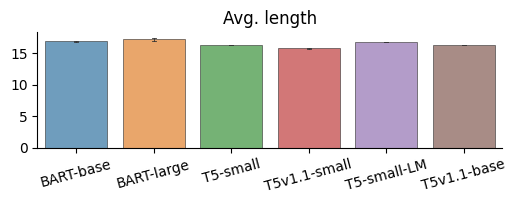

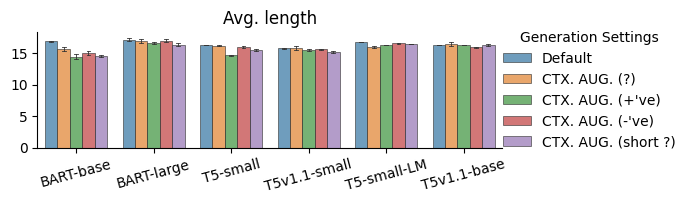

In [65]:
contrastive_model_barplot(
        df, 
        ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], 
        ['default'],
        tgt_metric='len_mean', 
        # save_as=f"resources/plots/all_public_models_default_{metric}"
    )

contrastive_model_barplot(
        df, 
        ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], 
        ['default', 'qu_ctxt_aug5', 'pos_sent_ctxt_aug5', 'neg_sent_ctxt_aug5', 'short_qu_ctxt_aug5'],
        tgt_metric='len_mean', 
        # save_as=f"resources/plots/all_public_models_default_{metric}"
    )

saving to resources/plots/all_public_models_default_uniq.* ...
saving to resources/plots/all_public_models_default_len_mean.* ...
saving to resources/plots/all_public_models_default_ppl_mean.* ...
saving to resources/plots/all_public_models_default_intra_dist1.* ...
saving to resources/plots/all_public_models_default_inter_dist1.* ...
saving to resources/plots/all_public_models_default_self_bleu.* ...
saving to resources/plots/all_public_models_default_bleu_t.* ...
saving to resources/plots/all_public_models_default_rouge1_t.* ...
saving to resources/plots/all_public_models_default_meteor_t.* ...


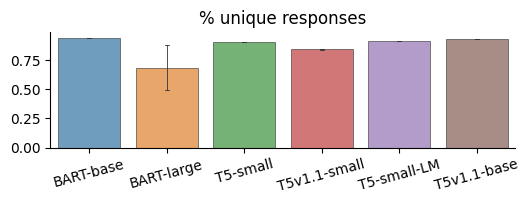

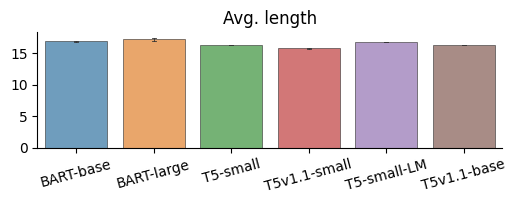

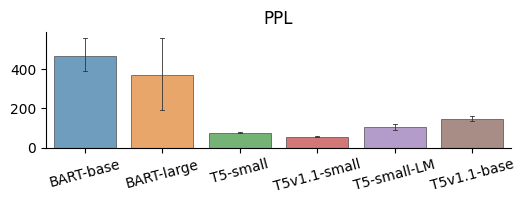

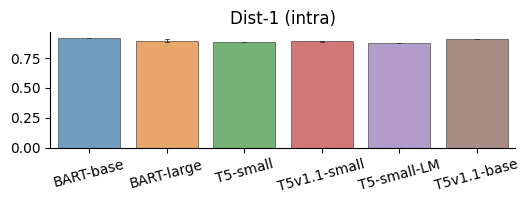

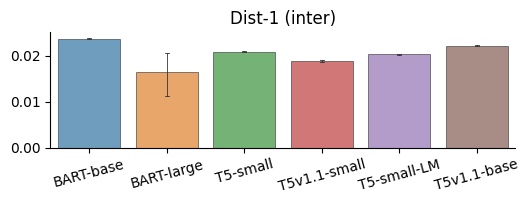

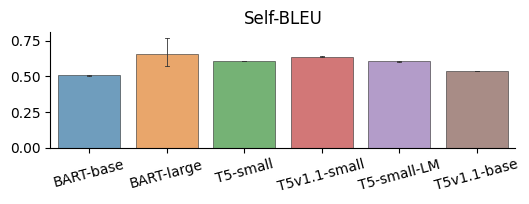

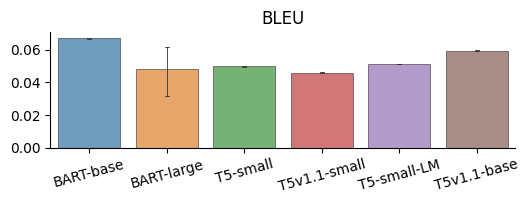

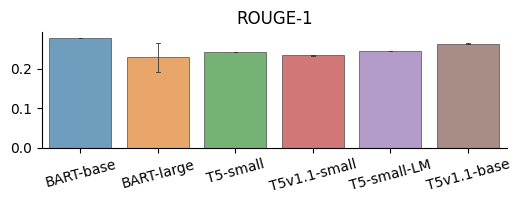

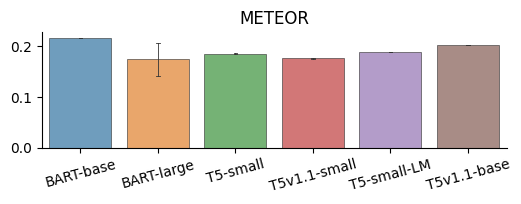

In [66]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(
        df, 
        ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], 
        ['default'], 
        tgt_metric=metric, 
        save_as=f"resources/plots/all_public_models_default_{metric}"
    )

saving to resources/plots/bart_small_default_uniq.* ...
saving to resources/plots/bart_small_default_len_mean.* ...
saving to resources/plots/bart_small_default_ppl_mean.* ...
saving to resources/plots/bart_small_default_intra_dist1.* ...
saving to resources/plots/bart_small_default_inter_dist1.* ...
saving to resources/plots/bart_small_default_self_bleu.* ...
saving to resources/plots/bart_small_default_bleu_t.* ...
saving to resources/plots/bart_small_default_rouge1_t.* ...
saving to resources/plots/bart_small_default_meteor_t.* ...


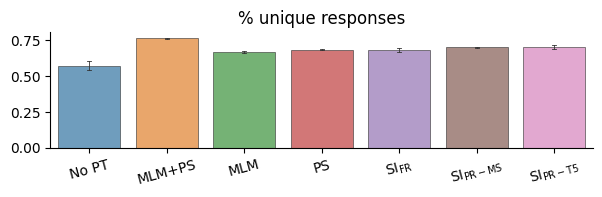

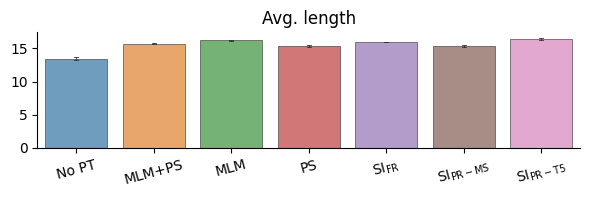

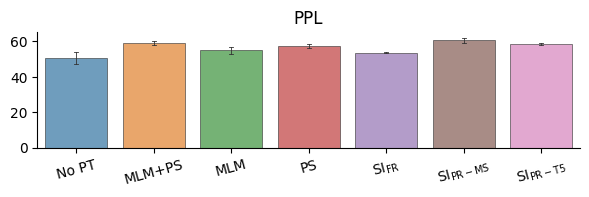

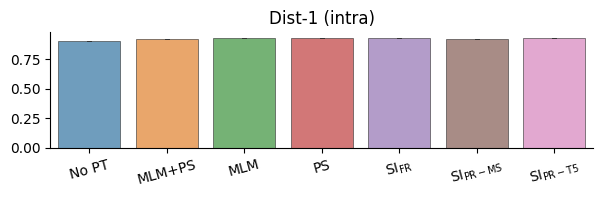

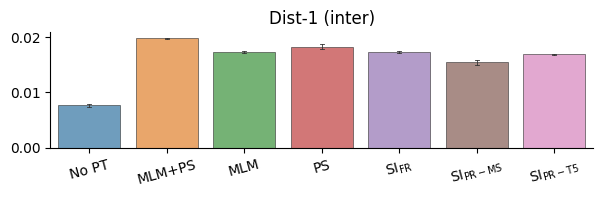

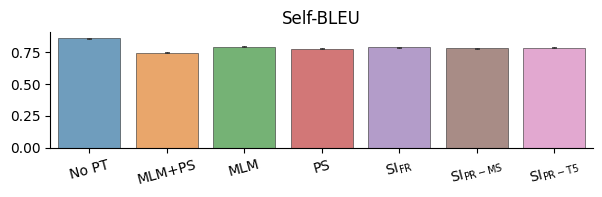

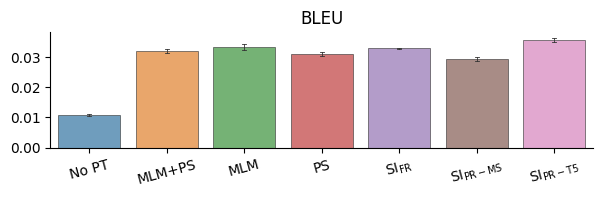

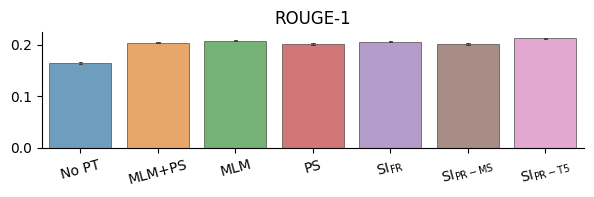

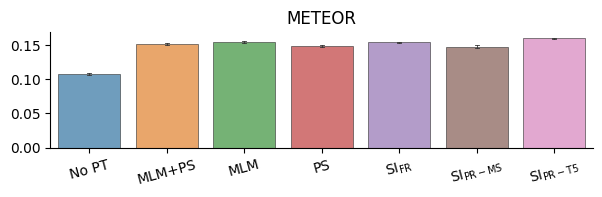

In [67]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(
        df, 
        ['bart_small_rndm', 'MLM+PS','MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)'], 
        ['default'], 
        tgt_metric=metric, 
        save_as=f"resources/plots/bart_small_default_{metric}"
    )

---

# Validation inference runs


In [68]:
# vdf = get_all_results([23, 42, 1984], results_dir='results/topchat_kgd_valid_freq_221014', build_dataframe=True)
vdf = get_all_results([23, 42, 1984], results_dir='results/topchat_kgd_valid_freq-bart_small', build_dataframe=True)
get_detailed_info_on_complex_dataframe(vdf)
vdf.head(5)


Found 30 models for seed 23: ['bart_small-SI_bart5_50', 'bart_small_rndm', 't5v11_base', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 't5_small', 'bart_large', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 't5v11_small', 'bart_small-SI_mass']
Found 336 results files in corresponding results directory (resources/models/seed_23/results/topchat_kgd_valid_freq-bart_small)
336 DFs have length 5
scaling ['self_bleu', 'bleu_t', 'bleu_k', 'bleu_d', 'bleu_s'] between [0,1]

Found 17 models for seed 42: ['bart_small-SI_bart5_50', 'bart_small_rndm', 't5v11_base', 'bart_sm

model_name_or_path  \
exp_seed model    gen_setting chkpt ft_data_size seed                                                   
23       SI(BART) default     2420  1.0          0     resources/models/seed_23/ft/bart_small-SI_bart   
                                                 42    resources/models/seed_23/ft/bart_small-SI_bart   
                                                 284   resources/models/seed_23/ft/bart_small-SI_bart   
                                                 983   resources/models/seed_23/ft/bart_small-SI_bart   
                                                 8630  resources/models/seed_23/ft/bart_small-SI_bart   

                                                        checkpoint_dir  \
exp_seed model    gen_setting chkpt ft_data_size seed                    
23       SI(BART) default     2420  1.0          0     checkpoint-2420   
                                                 42    checkpoint-2420   
                                                 284   checkpoint-2420   
                                                 983   checkpoint-2420   
                                                 8630  checkpoint-2420   

                                                       batch_size  \
exp_seed model    gen_setting chkpt ft_data_size seed               
23       SI(BART) default     2420  1.0          0            120   
                                                 42           120   
                                                 284          120   
                                                 983          120   
                                                 8630         120   

                                                                                             test_file  \
exp_seed model    gen_setting chkpt ft_data_size seed                                                    
23       SI(BART) default     2420  1.0          0     resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 42    resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 284   resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 983   resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 8630  resources/data/Topical-Chat/KGD/valid_freq.json   

                                                       data_seed  \
exp_seed model    gen_setting chkpt ft_data_size seed              
23       SI(BART) default     2420  1.0          0             0   
                                                 42            0   
                                                 284           0   
                                                 983           0   
                                                 8630          0   

                                                       max_predict_samples  \
exp_seed model    gen_setting chkpt ft_data_size seed                        
23       SI(BART) default     2420  1.0          0                     0.2   
                                                 42                    0.2   
                                                 284                   0.2   
                                                 983                   0.2   
                                                 8630                  0.2   

                                                       output_dir text_column  \
exp_seed model    gen_setting chkpt ft_data_size seed                           
23       SI(BART) default     2420  1.0          0            NaN       turns   
                                                 42           NaN       turns   
                                                 284          NaN       turns   
                                                 983          NaN       turns   
                                                 8630         NaN       turns   

         

Dataframe has length: 5030
336
24
plotting non-iterable - MODEL
qc_turn_level
('SI(T5)', 'default')
qc_turn_level
('SI(T5)', 'qu_ctxt_aug5')
336
24
plotting non-iterable - MODEL
pos_sents
('SI(T5)', 'default')
pos_sents
('SI(T5)', 'pos_sent_ctxt_aug5')
336
24
plotting non-iterable - MODEL
qc_turn_level
('SI(T5)', 'default')
qc_turn_level
('SI(T5)', 'single_qu_ctxt_aug5')
336
24
plotting non-iterable - MODEL
qc_turn_level
('SI(BART)', 'default')
qc_turn_level
('SI(BART)', 'qu_ctxt_aug5')
336
24
plotting non-iterable - MODEL
pos_sents
('SI(BART)', 'default')
pos_sents
('SI(BART)', 'pos_sent_ctxt_aug5')
336
24
plotting non-iterable - MODEL
qc_turn_level
('SI(BART)', 'default')
qc_turn_level
('SI(BART)', 'single_qu_ctxt_aug5')
336
24
plotting non-iterable - MODEL
qc_turn_level
('SI(MASS)', 'default')
qc_turn_level
('SI(MASS)', 'qu_ctxt_aug5')
336
24
plotting non-iterable - MODEL
pos_sents
('SI(MASS)', 'default')
pos_sents
('SI(MASS)', 'pos_sent_ctxt_aug5')
336
24
plotting non-iterable - MO

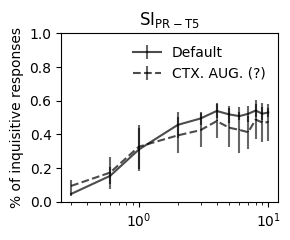

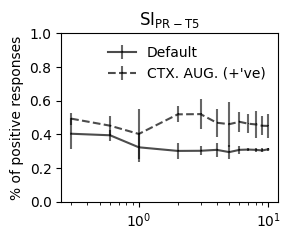

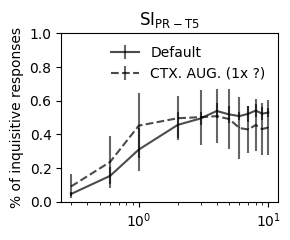

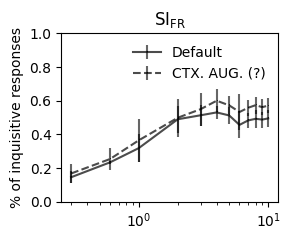

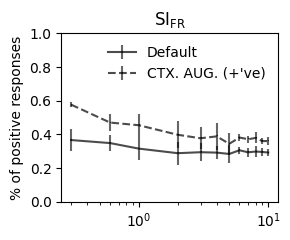

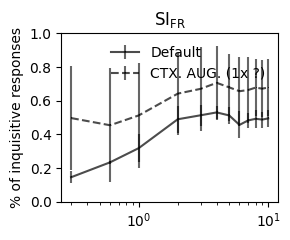

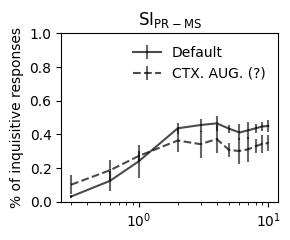

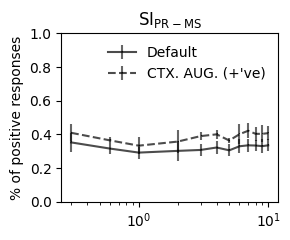

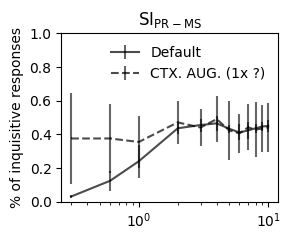

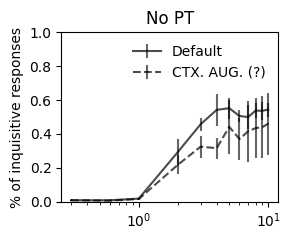

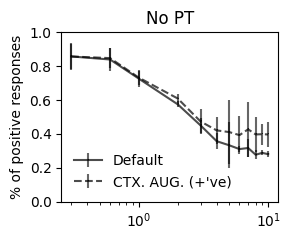

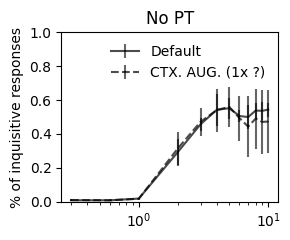

In [69]:
# plt.style.use('classic')
# plt.rcParams.update('IPython_default')
# sns.set_theme()
# sns.set_style("white")

def convert_steps_to_epochs(steps: List[int], max_epochs: int = 10) -> List[int]:
    if len(steps) == max_epochs:
        return list(range(1, max_epochs+1))
    elif len(steps) == max_epochs + 2:
        return [0.3, 0.6] + list(range(1, max_epochs+1))
    elif len(steps) < max_epochs:         # WARNING hardcoded!
        return [0.3, 0.6, 1, 2, 3, 4, 5] #, 6, 7, 8, 9, 10]

def plot_validation_scores_ablation(df, agg_ops={}, gen_settings_subset=None, models_subset=None, save_as=None, zoom_in=False, verbose=False):

    styles = ['-', '--', '-.']
    markers = ['^', 'p', '*']
    cmap = cm.get_cmap('tab10')(np.linspace(0, 1, 10)) # hack to get the colormap as a list of colors (https://stackoverflow.com/questions/70314497/convert-colormap-to-list)
    # print(cmap)

    line_styles = {
        'SI(BART)': cmap[0],
        'SI(T5)': cmap[1],
        'SI(MASS)': cmap[2],
        'bart_small_rndm': cmap[3],
        # 'default': markers[0],
        # 'qu_ctxt_aug1': markers[1],
        # 'qu_ctxt_aug5': markers[2],
        'default': styles[0],
        'qu_ctxt_aug1': styles[1],
        'qu_ctxt_aug5': styles[1],
        'excl_ctxt_aug5': styles[1],
        'pos_sent_ctxt_aug5': styles[1],
        'neg_sent_ctxt_aug5': styles[1],
        'single_qu_ctxt_aug5': styles[1],
    }
    
    group_by_cols = ['model', 'gen_setting', 'chkpt']
    
    if verbose:
        print(f'INDEX COLUMNS: {df.index.names}')
        print(f'GROUPING BY: {group_by_cols}')
        
    df = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
    print(len(df))
    
    # subset
    df = df.iloc[df.index.get_level_values('gen_setting').isin(gen_settings_subset)]
    df = df.iloc[df.index.get_level_values('model').isin(models_subset)]
    print(len(df))
    
    if zoom_in:
        df = df.iloc[df.index.get_level_values('chkpt') <= 36300]
        print(len(df))
    
    # initialize figure
    fig, axes = plt.subplots(nrows=1, ncols=len(agg_ops), figsize=(3*len(agg_ops), 2.5), sharex=True)

    if len(models_subset) == 1 and len(agg_ops) == 1:
        print('plotting non-iterable - MODEL')
        for model_idx, (model, dfs) in enumerate(df.groupby(['model', 'gen_setting'])):
            for metric_index, metric in enumerate(agg_ops.keys()):
                if verbose:
                    print(f'Plotting {model} {metric} on axis {metric_index} ...')

                x_vals = convert_steps_to_epochs(list(dfs.index.get_level_values('chkpt').values), 10)
                print(metric)
                print(model)
                markers, caps, bars = axes.errorbar(
                    x_vals, 
                    dfs[metric]['mean'].values,
                    yerr=dfs[metric]['std'].values,
                    label = name_mapping.get(model[1], model[1]),
                    marker = ',',
                    alpha = 0.7,
                    linestyle = line_styles[model[1]],
                    color = 'black' #line_styles[model[0]],
                    # fmt='-o'
                )

                [bar.set_alpha(0.6) for bar in bars]
                [cap.set_alpha(0.6) for cap in caps]
                
                axes.set_title(f'{name_mapping.get(model[0], model[0])}')
                axes.set_xticks(x_vals)
                axes.set_xticklabels(x_vals, rotation=0)
                lgd = axes.legend(frameon=False, loc='best')
                axes.set_xscale('log')
                axes.set_ylim([0.0, 1.0])
                axes.set_ylabel(f'{name_mapping.get(metric, metric)}')
                 
    
    elif len(agg_ops) == 1: # non-iterable axes version
        print('plotting non-iterable')
        for model_idx, (model, dfs) in enumerate(df.groupby(['model', 'gen_setting'])):
            for metric_index, metric in enumerate(agg_ops.keys()):
                if verbose:
                    print(f'Plotting {model} {metric} on axis {metric_index} ...')

                x_vals = convert_steps_to_epochs(list(dfs.index.get_level_values('chkpt').values), 10)
                print(metric)
                print(model)
                markers, caps, bars = axes.errorbar(
                    x_vals, 
                    dfs[metric]['mean'].values,
                    yerr=dfs[metric]['std'].values,
                    label = name_mapping.get(model[0], model[0]),
                    marker = ',',
                    alpha = 0.9,
                    linestyle = line_styles[model[1]],
                    color = line_styles[model[0]],
                    # fmt='-o'
                )

                [bar.set_alpha(0.6) for bar in bars]
                [cap.set_alpha(0.6) for cap in caps]
                
                axes.set_title(f'{name_mapping.get(metric, metric)}')
                axes.set_xticks(x_vals)
                axes.set_xticklabels(x_vals, rotation=0)
                lgd = axes.legend(frameon=False, )
                axes.set_xscale('log')
                axes.set_ylim([0.0, 1.0])
                
    else:
        for model_idx, (model, dfs) in enumerate(df.groupby(['model', 'gen_setting'])):
            for metric_index, (ax, metric) in enumerate(zip(axes, agg_ops.keys())):
                if verbose:
                    print(f'Plotting {model} {metric} on axis {metric_index}...')
                    
                x_vals = convert_steps_to_epochs(list(dfs.index.get_level_values('chkpt').values), 10)

                label = ' '.join([name_mapping.get(m, m) for m in model]) if metric_index == 0 else None
                
                markers, caps, bars = ax.errorbar(
                    x_vals, 
                    dfs[metric]['mean'].values,
                    yerr=dfs[metric]['std'].values,
                    label = label, 
                    marker = ',',
                    alpha = 0.9,
                    linestyle = line_styles[model[1]],
                    color = line_styles[model[0]],
                    )

                [bar.set_alpha(0.6) for bar in bars]
                [cap.set_alpha(0.6) for cap in caps]
                
                ax.set_title(f'{name_mapping.get(metric, metric)}')
                # print(x_vals)
                ax.set_xticks(x_vals)
                ax.set_xticklabels(x_vals, minor=False, rotation=0)

                # ax.set_xticks(x_vals[1::2])
                # ax.set_xticklabels(x_vals[1::2], minor=True, rotation=0)
                ax.set_xscale('log')
                # ax.set_yscale('log')
                
        lgd = fig.legend(
            bbox_to_anchor=(0.5, -0.12), 
            loc='center',
            ncol=len(models_subset)
        )
        
    fig.tight_layout()
    # plt.suptitle(f'Model checkpoint performance on validation set')
    
    if save_as is not None:
        # plt.savefig(save_as+'.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
        
        plt.savefig(save_as+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    
    return

print(f'Dataframe has length: {len(vdf)}')

for model in ['SI(T5)','SI(BART)','SI(MASS)','bart_small_rndm',]:
    plot_validation_scores_ablation(
        vdf, 
        agg_ops={
            'qc_turn_level': [np.mean, np.std],
            # 'uniq':[np.mean, np.std],
            # 'ppl_mean':[np.mean, np.std],
            # 'bleu_t': [np.mean, np.std], 
            # 'rouge1_s': [np.mean, np.std],
            }, 
        gen_settings_subset=['default', 'qu_ctxt_aug5'], 
        models_subset=[
            model
        ],
        save_as=f'resources/plots/epoch_qu_ctxt_aug5-{model}',
        zoom_in=False,
        verbose=False
    )
    
    plot_validation_scores_ablation(
        vdf, 
        agg_ops={
            'pos_sents': [np.mean, np.std],
            # 'uniq':[np.mean, np.std],
            # 'ppl_mean':[np.mean, np.std],
            # 'bleu_t': [np.mean, np.std], 
            # 'rouge1_s': [np.mean, np.std],
            }, 
        gen_settings_subset=['default', 'pos_sent_ctxt_aug5'], 
        models_subset=[
            model
        ],
        save_as=f'resources/plots/epoch_pos_sent_ctxt_aug5-{model}',
        zoom_in=False,
        verbose=False
    )
    

    plot_validation_scores_ablation(
        vdf, 
        agg_ops={
            'qc_turn_level': [np.mean, np.std],
            # 'uniq':[np.mean, np.std],
            # 'ppl_mean':[np.mean, np.std],
            # 'bleu_t': [np.mean, np.std], 
            # 'rouge1_s': [np.mean, np.std],
            }, 
        gen_settings_subset=['default', 'single_qu_ctxt_aug5'], 
        models_subset=[
            model
        ],
        save_as=f'resources/plots/epoch_single_qu_ctxt_aug5-{model}',
        zoom_in=False,
        verbose=False
    )
    
    # plot_validation_scores_ablation(
    #     vdf, 
    #     agg_ops={
    #         'pos_sents': [np.mean, np.std],
    #         # 'uniq':[np.mean, np.std],
    #         # 'ppl_mean':[np.mean, np.std],
    #         # 'bleu_t': [np.mean, np.std], 
    #         # 'rouge1_s': [np.mean, np.std],
    #         }, 
    #     gen_settings_subset=['default', 'pos_sent_ctxt_aug5'], 
    #     models_subset=[
    #         model
    #     ],
    #     save_as=f'resources/plots/epoch_pos_sent_ctxt_aug5-{model}',
    #     zoom_in=False,
    #     verbose=False
    # )

336
48


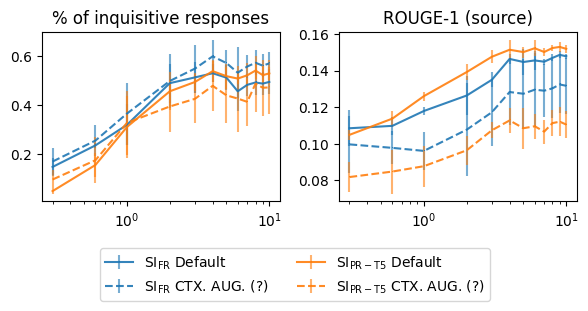

In [70]:
plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        'qc_turn_level': [np.mean, np.std],
        # 'uniq':[np.mean, np.std],
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        'rouge1_s': [np.mean, np.std],

        }, 
    gen_settings_subset=['default', 'qu_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        # 'SI(MASS)',
        # 'bart_small_rndm',
    ],
    save_as='resources/plots/epoch_qu_ctxt_aug5',
    zoom_in=False,
    verbose=False
)

# plot_validation_scores_ablation(
#     vdf, 
#     agg_ops={
#         # 'uniq':[np.mean, np.std],
#         # 'ppl_mean':[np.mean, np.std],
#         # 'bleu_t': [np.mean, np.std], 
#         'rouge1_s': [np.mean, np.std],
#         'qc_turn_level': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['default', 'qu_ctxt_aug5'], 
#     models_subset=[
#         'SI(T5)',
#         'SI(BART)',
#         # 'SI(MASS)',
#         # 'bart_small_rndm',
#     ],
#     save_as='resources/plots/epoch_validation_metrics-qu_ctxt_aug5_with_rouge',
#     zoom_in=False,
#     verbose=False
# )

336
48


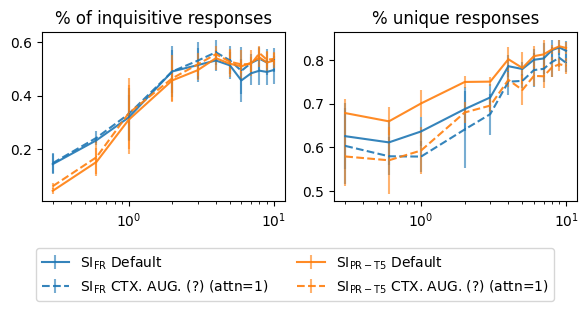

In [71]:
plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        'qc_turn_level': [np.mean, np.std],
        'uniq':[np.mean, np.std],
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        # 'rouge1_s': [np.mean, np.std],
        
        }, 
    gen_settings_subset=['default', 'qu_ctxt_aug1'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        # 'SI(MASS)',
        # 'bart_small_rndm',
    ],
    save_as='resources/plots/epoch_qu_sents1',
    zoom_in=False,
    verbose=False
)


336
48


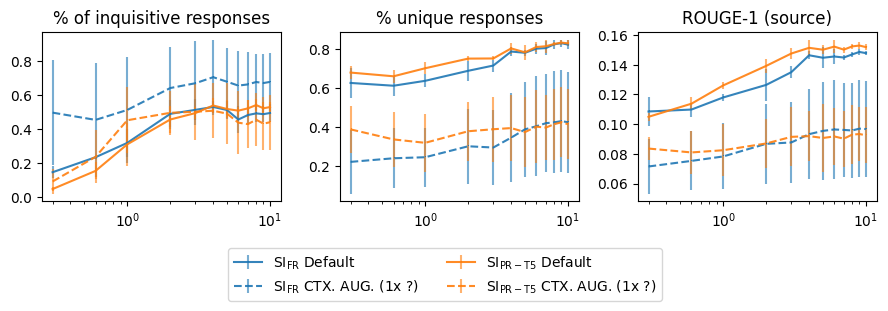

In [72]:
plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        'qc_turn_level': [np.mean, np.std],
        'uniq':[np.mean, np.std],
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        'rouge1_s': [np.mean, np.std],
        }, 
    gen_settings_subset=['default', 'single_qu_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        # 'SI(MASS)',
        # 'bart_small_rndm',
    ],
    save_as='resources/plots/epoch_single_qu_sents',
    verbose=False
)

336
48


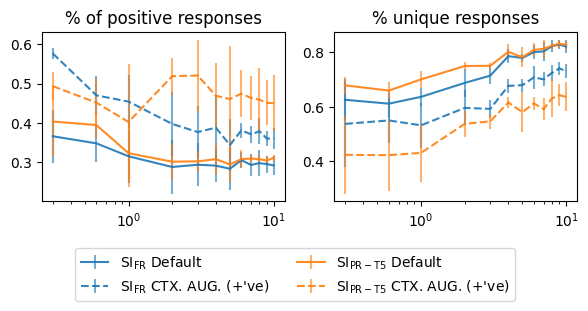

In [73]:
plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        'pos_sents': [np.mean, np.std],
        'uniq':[np.mean, np.std],
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        # 'rouge1_s': [np.mean, np.std],
        
        }, 
    gen_settings_subset=['default', 'pos_sent_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        # 'SI(MASS)',
        # 'bart_small_rndm',
    ],
    save_as='resources/plots/epoch_pos_sents',
    verbose=False
)


336
48


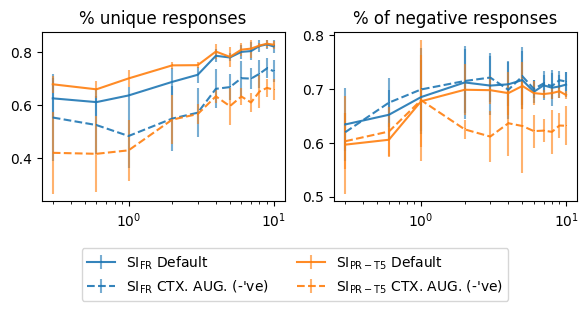

In [74]:
plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        'uniq':[np.mean, np.std],
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        # 'rouge1_s': [np.mean, np.std],
        'neg_sents': [np.mean, np.std],
        }, 
    gen_settings_subset=['default', 'neg_sent_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        # 'SI(MASS)',
        # 'bart_small_rndm',
    ],
    save_as='resources/plots/epoch_neg_sents',
    verbose=False
)


336
96


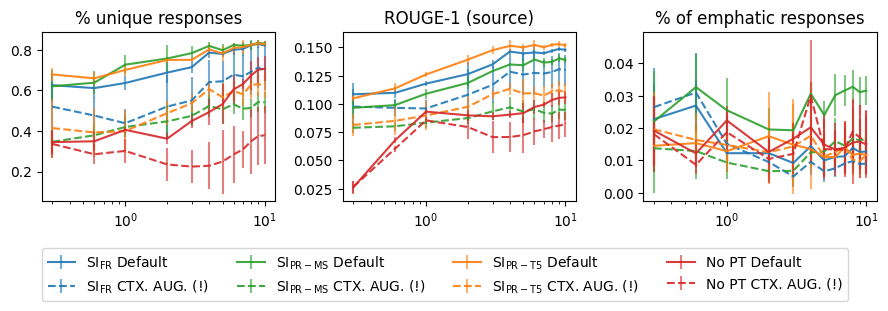

In [75]:
plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        'uniq':[np.mean, np.std],
        # 'ppl_mean':[np.mean, np.std],
        # 'rouge1_t': [np.mean, np.std],
        'rouge1_s': [np.mean, np.std],
        'ec_turn_level': [np.mean, np.std],
        }, 
    gen_settings_subset=['default', 'excl_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        'SI(MASS)',
        'bart_small_rndm',
    ],
    save_as='resources/plots/epoch_excl_sents',
    verbose=False
)


# Inspect single Qu CTX AUG

In [41]:
simdf = pd.read_csv('resources/single_qu_ctxt_similarity_scores.csv')
INDEX_LEVELS = ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
index_cols = {'Unnamed: 0': 'exp_seed', 'Unnamed: 1': 'model', 'Unnamed: 2': 'seed'}
simdf['gen_setting'] = 'single_qu_ctxt_aug5'
simdf['chkpt'] = 'best'
simdf['ft_data_size'] = 1.0
simdf.rename(columns=index_cols, inplace=True)
simdf.set_index(INDEX_LEVELS, drop=True, inplace=True)
simdf.head(10)

bertscore_f1_mean  \
exp_seed model          gen_setting         chkpt ft_data_size seed                      
23       bart_base      single_qu_ctxt_aug5 best  1.0          0              0.937376   
                                                               42             0.710738   
                                                               284            0.742568   
                                                               983            0.723059   
                                                               8630           0.873311   
         bart_small-MLM single_qu_ctxt_aug5 best  1.0          0              0.989428   
                                                               42             0.706360   
                                                               284            0.699999   
                                                               983            0.670763   
                                                               8630           0.701398   

                                                                     bertscore_f1_std  \
exp_seed model          gen_setting         chkpt ft_data_size seed                     
23       bart_base      single_qu_ctxt_aug5 best  1.0          0             0.086348   
                                                               42            0.074777   
                                                               284           0.073497   
                                                               983           0.058088   
                                                               8630          0.101170   
         bart_small-MLM single_qu_ctxt_aug5 best  1.0          0             0.041498   
                                                               42            0.072571   
                                                               284           0.047240   
                                                               983           0.041606   
                                                               8630          0.060115   

                                                                                                                          bertscore_hashcode  \
exp_seed model          gen_setting         chkpt ft_data_size seed                                                                            
23       bart_base      single_qu_ctxt_aug5 best  1.0          0     distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               42    distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               284   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               983   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               8630  distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
         bart_small-MLM single_qu_ctxt_aug5 best  1.0          0     distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               42    distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               284   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               983   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               8630  distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   

                                                                     bertscore_precision_mean  \
exp_seed model          gen_setting         chkpt ft_data_size seed                          

saving to resources/plots/public_models_single_qu_ctxt_similarity_bertscore_f1_mean.* ...
saving to resources/plots/public_models_single_qu_ctxt_similarity_rouge1.* ...
saving to resources/plots/public_models_single_qu_ctxt_similarity_bleu.* ...
saving to resources/plots/public_models_single_qu_ctxt_similarity_exact_match.* ...
saving to resources/plots/mini_models_single_qu_ctxt_similarity_bertscore_f1_mean.* ...
saving to resources/plots/mini_models_single_qu_ctxt_similarity_rouge1.* ...
saving to resources/plots/mini_models_single_qu_ctxt_similarity_bleu.* ...
saving to resources/plots/mini_models_single_qu_ctxt_similarity_exact_match.* ...


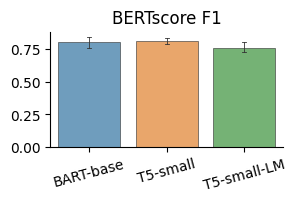

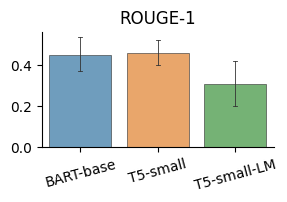

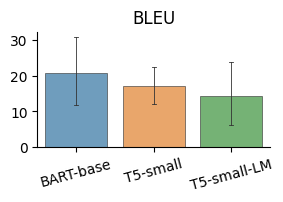

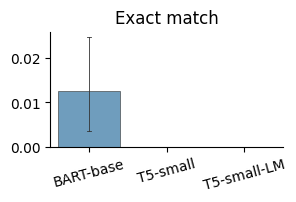

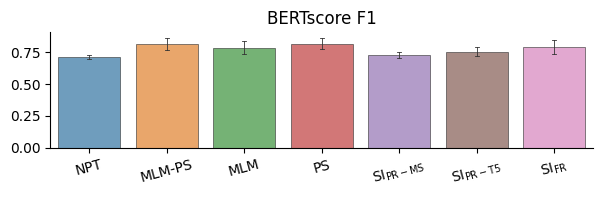

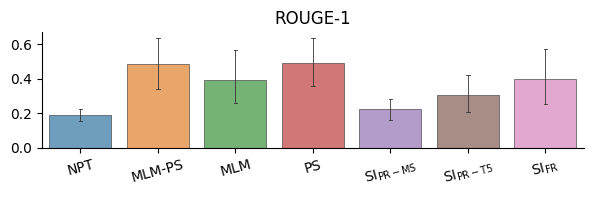

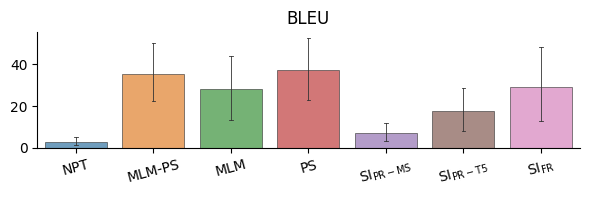

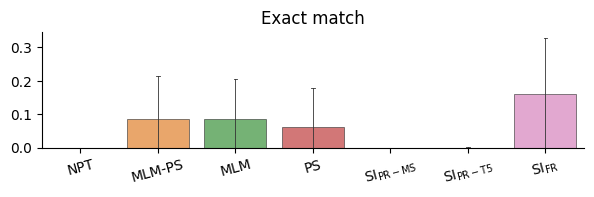

In [42]:
for metric in ['bertscore_f1_mean', 'rouge1', 'bleu', 'exact_match']:
    contrastive_model_barplot(
        simdf,
        ['bart_base', 't5_small', 't5_lm_small'], 
        ['single_qu_ctxt_aug5'], 
        tgt_metric=metric, 
        save_as=f"resources/plots/public_models_single_qu_ctxt_similarity_{metric}"
    )
    
for metric in ['bertscore_f1_mean', 'rouge1', 'bleu', 'exact_match']:
    contrastive_model_barplot(
        simdf,
        ['bart_small_rndm', 'bart_small-MLM_PS', 'bart_small-MLM', 'bart_small-PS', 'bart_small-SI_mass', 'bart_small-SI_t5', 'bart_small-SI_bart'], 
        ['single_qu_ctxt_aug5'],
        tgt_metric=metric, 
        save_as=f"resources/plots/mini_models_single_qu_ctxt_similarity_{metric}"
    )

In [43]:
simdf = pd.read_csv('resources/seed_ctxt_pos_similarity_scores.csv')
INDEX_LEVELS = ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
index_cols = {'Unnamed: 0': 'exp_seed', 'Unnamed: 1': 'model', 'Unnamed: 2': 'seed'}
simdf['gen_setting'] = 'single_qu_ctxt_aug5'
simdf['chkpt'] = 'best'
simdf['ft_data_size'] = 1.0
simdf.rename(columns=index_cols, inplace=True)
simdf.set_index(INDEX_LEVELS, drop=True, inplace=True)
simdf.head(10)

bertscore_f1_mean  \
exp_seed model          gen_setting         chkpt ft_data_size seed                      
23       bart_base      single_qu_ctxt_aug5 best  1.0          0              0.761310   
                                                               42             0.791874   
                                                               284            0.792571   
                                                               983            0.723468   
                                                               8630           0.722662   
         bart_small-MLM single_qu_ctxt_aug5 best  1.0          0              0.707520   
                                                               42             0.760214   
                                                               284            0.760290   
                                                               983            0.694042   
                                                               8630           0.694569   

                                                                     bertscore_f1_std  \
exp_seed model          gen_setting         chkpt ft_data_size seed                     
23       bart_base      single_qu_ctxt_aug5 best  1.0          0             0.052468   
                                                               42            0.105436   
                                                               284           0.105454   
                                                               983           0.046518   
                                                               8630          0.046203   
         bart_small-MLM single_qu_ctxt_aug5 best  1.0          0             0.050785   
                                                               42            0.090494   
                                                               284           0.089070   
                                                               983           0.047893   
                                                               8630          0.047650   

                                                                                                                          bertscore_hashcode  \
exp_seed model          gen_setting         chkpt ft_data_size seed                                                                            
23       bart_base      single_qu_ctxt_aug5 best  1.0          0     distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               42    distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               284   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               983   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               8630  distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
         bart_small-MLM single_qu_ctxt_aug5 best  1.0          0     distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               42    distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               284   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               983   distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   
                                                               8630  distilbert-base-uncased_L5_no-idf_version=0.3.12(hug_trans=4.22.0.dev0)   

                                                                     bertscore_precision_mean  \
exp_seed model          gen_setting         chkpt ft_data_size seed                          

saving to resources/plots/public_models_single_pos_ctxt_similarity_bertscore_f1_mean.* ...
saving to resources/plots/public_models_single_pos_ctxt_similarity_rouge1.* ...
saving to resources/plots/public_models_single_pos_ctxt_similarity_bleu.* ...
saving to resources/plots/public_models_single_pos_ctxt_similarity_exact_match.* ...
saving to resources/plots/mini_models_single_pos_ctxt_similarity_bertscore_f1_mean.* ...
saving to resources/plots/mini_models_single_pos_ctxt_similarity_rouge1.* ...
saving to resources/plots/mini_models_single_pos_ctxt_similarity_bleu.* ...
saving to resources/plots/mini_models_single_pos_ctxt_similarity_exact_match.* ...


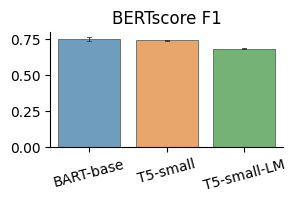

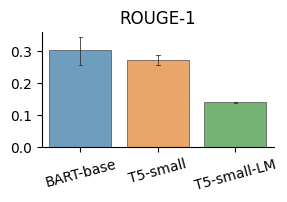

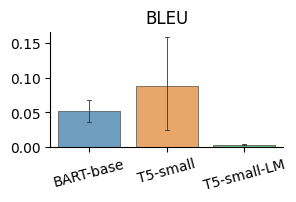

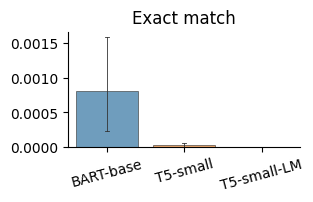

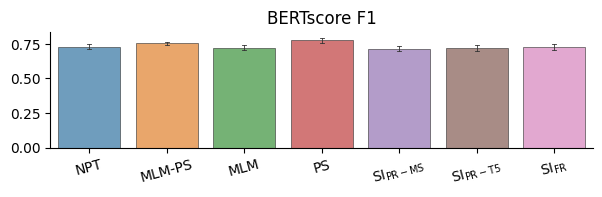

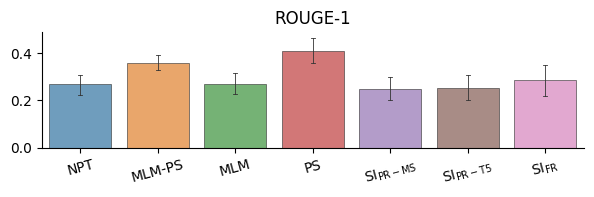

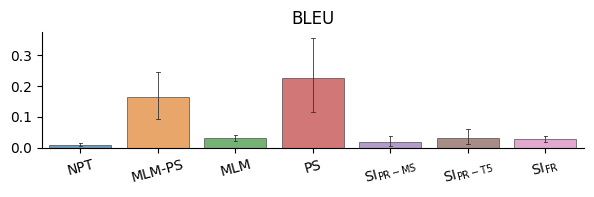

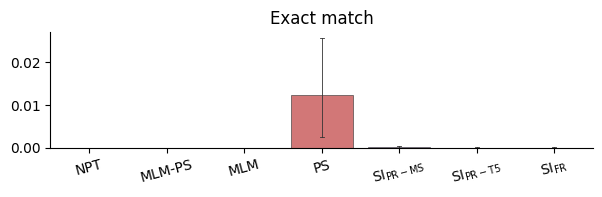

In [44]:
for metric in ['bertscore_f1_mean', 'rouge1', 'bleu', 'exact_match']:
    contrastive_model_barplot(
        simdf,
        ['bart_base', 't5_small', 't5_lm_small'], 
        ['single_qu_ctxt_aug5'],
        tgt_metric=metric, 
        save_as=f"resources/plots/public_models_single_pos_ctxt_similarity_{metric}"
    )
    
for metric in ['bertscore_f1_mean', 'rouge1', 'bleu', 'exact_match']:
    contrastive_model_barplot(
        simdf,
        ['bart_small_rndm', 'bart_small-MLM_PS', 'bart_small-MLM', 'bart_small-PS', 'bart_small-SI_mass', 'bart_small-SI_t5', 'bart_small-SI_bart'], 
        ['single_qu_ctxt_aug5'], 
        tgt_metric=metric, 
        save_as=f"resources/plots/mini_models_single_pos_ctxt_similarity_{metric}"
    )

In [45]:
# from evaluation.reference_metrics import compute_rouge, compute_exact_match, compute_bertscore
# from evaluation.eval import read_lines

---

## Ablations - Fine-tuning dataset size

In [172]:
# def plot_data_size_ablation(df, agg_ops={}, gen_settings_subset=None, models_subset=None, verbose=False):
    
#     group_by_cols = ['model', 'gen_setting', 'ft_data_size']
#     if verbose:
#         print(f'INDEX COLUMNS: {df.index.names}')
#         print(f'GROUPING BY: {group_by_cols}')
        
#     dfa = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
    
#     # subset
#     dfs = dfa.iloc[dfa.index.get_level_values('gen_setting').isin(gen_settings_subset)]
#     dfs = dfs.iloc[dfs.index.get_level_values('model').isin(models_subset)]

#     # initialize figure
#     fig, axes = plt.subplots(nrows=1, ncols=len(agg_ops), figsize=(4*len(agg_ops), 3.5), sharex=True)

#     if len(agg_ops) == 1: # non-iterable axes version
#         for model, df in dfs.groupby(['model', 'gen_setting']):
#             for k in agg_ops.keys():
#                 if verbose:
#                     print(f'Plotting {model} {k} on axis {i} ...')

#                 x_vals = df.index.get_level_values('ft_data_size').values
#                 axes.errorbar(
#                         x_vals, 
#                         df[k]['mean'].values,
#                         yerr=df[k]['std'].values,
#                         label = model[0], # ' '.join(list(model)),
#                         marker = 'o',
#                         alpha=0.8,
#                         linestyle = '-',
#                         # fmt='-o'
#                     )

#                 axes.set_title(f'{k}')
#                 axes.set_xticks(x_vals)
#                 axes.legend(frameon=False)
    
#     else:
#         for model, df in dfs.groupby(['model', 'gen_setting']):
#             for ax, k in zip(axes, agg_ops.keys()):
#                 if verbose:
#                     print(f'Plotting {model} {k} on axis {i} ...')

#                 x_vals = df.index.get_level_values('ft_data_size').values
#                 ax.errorbar(
#                         x_vals, 
#                         df[k]['mean'].values,
#                         yerr=df[k]['std'].values,
#                         label = model[0], # ' '.join(list(model)),
#                         marker = 'o',
#                         alpha=0.8,
#                         linestyle = '-',
#                         # fmt='-o'
#                     )

#                 ax.set_title(f'{k}')
#                 ax.set_xticks(x_vals)
#                 ax.legend(frameon=False)

#     plt.suptitle(f'Generation setting: {", ".join(gen_settings_subset)}')
    
#     return

# print(f'Dataframe has length: {len(df)}')
# # plot_data_size_ablation(df, agg_ops=agg_ops, subset=['default', 'xa_dialog', 'xa_knowledge'])
# # plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# # plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# # plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_dialog'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# # plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_knowledge'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# # plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std], 'bleu_k': [np.mean, np.std], 'novelty_k_1gram': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         # 'ppl_mean': [np.mean, np.std],
#         # 'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         'qc_turn_level': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['default'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )

# # plot_data_size_ablation(
# #     df, 
# #     agg_ops={
# #         'ppl_mean': [np.mean, np.std],
# #         'uniq': [np.mean, np.std],
# #         'bleu_t': [np.mean, np.std], 
# #         'rouge1_k': [np.mean, np.std],
# #         'rouge1_d': [np.mean, np.std],
# #         'novelty_k_1gram': [np.mean, np.std], 
# #         'novelty_d_1gram': [np.mean, np.std],
# #         'intra_dist1': [np.mean, np.std], 
# #         'inter_dist1': [np.mean, np.std],
# #         }, 
# #     gen_settings_subset=['xa_dialog'], 
# #     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# # )

# # plot_data_size_ablation(
# #     df, 
# #     agg_ops={
# #         'ppl_mean': [np.mean, np.std],
# #         'uniq': [np.mean, np.std],
# #         'bleu_t': [np.mean, np.std], 
# #         'rouge1_k': [np.mean, np.std],
# #         'rouge1_d': [np.mean, np.std],
# #         'novelty_k_1gram': [np.mean, np.std], 
# #         'novelty_d_1gram': [np.mean, np.std],
# #         'intra_dist1': [np.mean, np.std], 
# #         'inter_dist1': [np.mean, np.std],
# #         }, 
# #     gen_settings_subset=['xa_knowledge'], 
# #     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# # )

# # plot_data_size_ablation(
# #     df, 
# #     agg_ops={
# #         'ppl_mean': [np.mean, np.std],
# #         'uniq': [np.mean, np.std],
# #         'bleu_t': [np.mean, np.std], 
# #         'rouge1_k': [np.mean, np.std],
# #         'rouge1_d': [np.mean, np.std],
# #         'novelty_k_1gram': [np.mean, np.std], 
# #         'novelty_d_1gram': [np.mean, np.std],
# #         'intra_dist1': [np.mean, np.std], 
# #         'inter_dist1': [np.mean, np.std],
# #         }, 
# #     gen_settings_subset=['xa_dialog+qu_ctxt_aug5'], 
# #     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# # )

# # plot_data_size_ablation(
# #     df, 
# #     agg_ops={
# #         'ppl_mean': [np.mean, np.std],
# #         'uniq': [np.mean, np.std],
# #         'bleu_t': [np.mean, np.std], 
# #         'rouge1_k': [np.mean, np.std],
# #         'rouge1_d': [np.mean, np.std],
# #         'novelty_k_1gram': [np.mean, np.std], 
# #         'novelty_d_1gram': [np.mean, np.std],
# #         'intra_dist1': [np.mean, np.std], 
# #         'inter_dist1': [np.mean, np.std],
# #         }, 
# #     gen_settings_subset=['xa_knowledge+qu_ctxt_aug5'], 
# #     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# # )



In [40]:
# import matplotlib.colors as mcolors
# colors = [mcolors.to_hex(plt.cm.tab20(i)) for i in range(20)]
# # patterns = ['', '\\', '+', 'x', '.', '*', 'o', 'O',]
# hpatterns = ['', '\\', '\\\\', '/', '//', '|', '||'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]
# vpatterns = ['', '\\', '\\\\', '/', '//', '-', '--'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]

# def build_bar_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', horizontal: bool = False, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=0)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     build_bar(data, horizontal=horizontal, verbose=verbose)
    
#     return


# def build_bar(data: Dict, horizontal: bool = True, verbose: bool = True):

#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#     positions = []
#     means = []
#     stds = []
#     bar_colors = []
#     bar_patterns = []
#     labels = []
    
#     pos = 0
#     for i, (model, gen_settings) in enumerate(data.items()):
#         # TODO make groups for colors and build legend
#         # https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
# #                 group = {model: {}}
#         for j, (gen_setting, scores) in enumerate(gen_settings.items()):

#             labels.append(f'{model} {gen_setting}')
            
#             if not horizontal:
#                 ax.bar(
#                     x = pos,
#                     height = scores.mean(),
#                     yerr=scores.std(), 
#                     color=colors[i],
#                     hatch=vpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             else:
#                 ax.barh(
#                     y = pos,
#                     width = scores.mean(),
#                     xerr=scores.std(), 
#                     color=colors[i],
#                     hatch=hpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             pos += 1 # incrememt pos for next bar
        
#         if not horizontal:
#             ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=45)
#         else:
#             ax.set_yticks(np.arange(len(labels)), labels=labels)
# #         ax.legend()
        
# dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)

# # dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# # build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)




In [ ]:
# agg_ops = {
#     'rouge1_t': np.mean,
#     'rougeL_t': np.mean,
#     'rouge1_k': np.mean,
#     'rougeL_k': np.mean,
#     'rouge1_d': np.mean,
#     'rougeL_d': np.mean,
#     'rouge1_s': np.mean,
#     'rougeL_s': np.mean,
#     'rougeL_s': np.mean,
#     'qc_turn_level': np.mean,
# }

# print(f'Dataframe has length: {len(df)}')
# dfs = df.iloc[df.index.get_level_values('ft_data_size') == 1.0] # select only those entries which use 100% fine-tuning data
# print(f'Dataframe has length: {len(dfs)}')
# dfa = aggregate_values_for_target_metric(dfs, agg_ops=agg_ops)
# dfa
# def plot_rouge(df):
#     df = df.stack().unstack(0)
#     # df = df.reset_index(level=1, drop=True) # re
#     return df
# dfp = plot_rouge(dfa)
# dfp

In [9]:
# OLD PLOTS

# def parse_title(title):
#     title = title.replace('bart_small', '')
#     title = title.replace('(denoising)', '')
#     title = title.replace('(denoising_t5)', 't5-style')
#     return title

# def build_violinplot(data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))

#     if verbose:
#         print('Data:', data)

#     positions = range(1, len(data)+1)[::-1] # reveserse to have defualt at top
#     labels = list(data.keys())[::-1] # reveserse to have defualt at top
    
#     vp1 = ax.violinplot(
#         dataset = list(data.values()),
#         positions=positions,
#         points=30, widths=0.4,
#         showmeans=True, showextrema=True, showmedians=False,
#         vert=False,
#     )
#     if baseline_reference_data:
#         vp2 = ax.violinplot(
#             dataset = list(baseline_reference_data.values()),
#             positions=positions,
#             points=30, widths=0.4,
#             showmeans=True, showextrema=True, showmedians=False,
#             vert=False,
#         )

#         # create legend (currently v. rough)
#         # plt.legend([vp1['bodies'][0], vp2['bodies'][0]], [title, 'default'], loc=2)
        
#     # make title
#     ax.set_title(parse_title(title)) 
    
#     # label yaxis ticks
#     ax.yaxis.set_tick_params(direction='out') 
#     ax.yaxis.set_ticks_position('left')
#     ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
# #     ax.set_ylabel('Generation setting')
    
#     # set xaxis limits
#     min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#     max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#     print(f'min={min_val}, max={max_val}')
#     ax.set_xlim(min_val, max_val) #, + 0.75)

#     return fig


# def build_violinplot_subfig(data: Dict, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    
#     print('BASELINE model provided:', baseline_reference_key)
# #     baseline_reference_data = data.pop(baseline_reference_key) if baseline_reference_key is not None else None
#     baseline_reference_data = data.get(baseline_reference_key)
#     model_array = list(data.keys())
#     print(f'Plotting for models: {model_array}')
    
#     if len(model_array) <= 3:
#         # setup fig based on split arrays 1D
        
#         print('Building single row plots...')
#         nrows = 1
#         ncols = len(model_array)
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
#         for i, model in enumerate(model_array):
            
#             model_results = data[model]

#             if baseline_reference_key is not None and baseline_reference_key != model:
#                 positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
#                 labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
#                 print(f'Plotting {model} on axes at position {i}')
#                 vp1 = axes[i].violinplot(
#                     dataset = list(data[model].values()),
#                     positions=positions,
#                     points=30, widths=0.4,
#                     showmeans=True, showextrema=True, showmedians=False,
#                     vert=False,
#                 )
#                 if baseline_reference_data:
#                     vp2 = axes[i].violinplot(
#                         dataset = list(baseline_reference_data.values()),
#                         positions=positions,
#                         points=30, widths=0.4,
#                         showmeans=True, showextrema=True, showmedians=False,
#                         vert=False,
#                     )
#                 # make title
#                 axes[i].set_title(parse_title(model))

#         # label yaxis ticks
#         axes[0].yaxis.set_tick_params(direction='out') 
#         axes[0].yaxis.set_ticks_position('left')
#         axes[0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#     #     axes[0].set_ylabel('Generation setting')

#     #     # set xaxis limits
#         min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#         max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#         print(f'min={min_val}, max={max_val}')
#         axes[0].set_xlim(min_val, max_val) #, + 0.75)
    
#     else:
#         print('Building multi-row (2D) 3xN plots...')
#         # setup fig based on split arrays 2D
#         if len(model_array) <= 6:
#             nrows = 2
#         elif len(model_array) <= 9:
#             nrows = 3
#         elif len(model_array) <= 12:
#             nrows = 4
        
#         model_array = np.array_split(model_array, nrows)
#         ncols = max([len(a) for a in model_array])
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
#         for i, row in enumerate(model_array):
#             for j, model in enumerate(row):
# #                 if baseline_reference_key is not None and baseline_reference_key != model:
#                 positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
#                 labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
#                 print(f'Plotting {model} on axis at position {i}, {j}')
#                 vp1 = axes[i][j].violinplot(
#                     dataset = list(data[model].values()),
#                     positions=positions,
#                     points=30, widths=0.4,
#                     showmeans=True, showextrema=True, showmedians=False,
#                     vert=False,
#                 )
#                 if baseline_reference_data:
#                     vp2 = axes[i][j].violinplot(
#                         dataset = list(baseline_reference_data.values()),
#                         positions=positions,
#                         points=30, widths=0.4,
#                         showmeans=True, showextrema=True, showmedians=False,
#                         vert=False,
#                     )
#                 # make title
#                 axes[i][j].set_title(parse_title(model))

#             # label yaxis ticks
#             axes[0][0].yaxis.set_tick_params(direction='out') 
#             axes[0][0].yaxis.set_ticks_position('left')
#             axes[0][0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#             # axes[0][0].set_ylabel('Generation setting')

#             # set xaxis limits
#             min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#             max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#             print(f'min={min_val}, max={max_val}')
#             axes[0][0].set_xlim(min_val, max_val) #, + 0.75)

#     plt.suptitle(target_metric)
#     plt.tight_layout()

#     return fig

# def build_violin_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=1)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=2)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     if verbose:
#         print('Data:')
#         print(data)
        
#     baseline_reference_data = data[baseline_reference_key] if baseline_reference_key is not None else None
    
#     # make violins for each model
#     for model, results in data.items():
#         if baseline_reference_key and baseline_reference_key != model:
#             fig = build_violinplot(results, f'{model} ({target_metric})', baseline_reference_data, min_val, max_val, verbose=verbose)
#             if save:
#                 outpath = str(plot_path / f'{model}-{target_metric}.png')
#                 fig.savefig(outpath, dpi='figure', bbox_inches='tight')
#                 print(f'saved {outpath}')
    
#     # make a subfig for all models
#     fig = build_violinplot_subfig(data, target_metric, baseline_reference_key, min_val, max_val, verbose=verbose)
#     if save:
#         outpath = str(plot_path / f'{baseline_reference_key}_vs_all-{target_metric}.png')
#         fig.savefig(outpath, dpi='figure', bbox_inches='tight')
#         print(f'saved {outpath}')
 
#     return

# # TODO: update!

# # compare bart_base with bart_small
# # dff = df[df.index.isin(['bart_base', 'bart_small(denoising)'], level=0)]
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)

# # # # compare all bart_small models
# # dff = df.iloc[~df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
# # print(len(dff))
# # dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
# # print(len(dff))
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='MLM+PS', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='MLM+PS', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='MLM+PS', save=True, verbose=False)

# # # # # compare off-the-shelf fine-tuned models
# # dff = df.iloc[df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
# # print(len(dff))
# # dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
# # print(len(dff))
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='bart_base', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='bart_base', save=True, verbose=False)

